<a href="https://colab.research.google.com/github/DavidEPP/NLP_disaster_tweet_classifier/blob/main/RNN_for_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [23]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')


100%|██████████| 593k/593k [00:00<00:00, 68.0MB/s]

Extracting files...
Data source import complete.


# RNN classification models for disaster tweets

This is a jupyter notebook for a Kaggle competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available.

The model uses Keras library
<img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="50"><br/>.


The following steps are included in the document:
- Load the Training and test data
- Explore the dataset
- Preprocess the text
- Create two architectures and fine tune models
- Generate a submission file


In [24]:
import os
import numpy as np
import pandas as pd
import pickle
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.metrics import F1Score, BinaryAccuracy


from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns

## Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [25]:
print (f"The data is loaded to {nlp_getting_started_path}")
df_train = pd.read_csv(f"{nlp_getting_started_path}/train.csv")
df_test = pd.read_csv(f"{nlp_getting_started_path}/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

The data is loaded to /root/.cache/kagglehub/competitions/nlp-getting-started
Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [26]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [27]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

## Explore the dataset

Some exploratory analtisis is done in the dataset, this incudes checking for frequencies of each class of target and checking for duplicates and inconsistencies in the data.

In [28]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [29]:
print(df_train.isna().sum())
print(df_test.isna().sum())

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64
id             0
keyword       26
location    1105
text           0
length         0
dtype: int64


We can note that some of the tweets do not include a keyword or a location. In the first attempt, those will not be considered.

In [30]:
print (f'{len(df_train["location"].unique())} different locations')
print (f'{len(df_train["keyword"].unique())} different keywords')

3342 different locations
222 different keywords


We can check for inconsistent tags (same text with different target).

In [31]:
# Count the duplicated values in the 'Text' column
duplicated_text_count = df_train.duplicated(subset=['text']).sum()

# Count the duplicated values based on both 'Text' and 'Category'. If the counts are the same as above,those duplicates have consistent 'Category'
duplicated_textcat_count = df_train.duplicated(subset=['text', 'target']).sum()

# Print the counts
print(f'There are {duplicated_text_count} rows with the same texts in the training data.')
print(f'There are {duplicated_textcat_count} rows with the same texts and categories in the training data.')





There are 110 rows with the same texts in the training data.
There are 92 rows with the same texts and categories in the training data.


There are some registers with the same text but different tag. These should be excluded from the study

In [32]:
inconsistent_texts = (
    df_train.groupby('text')['target']
    .nunique()
    .loc[lambda x: x > 1]  # Find names with more than 1 unique tag
    .index
)

print(f"There are {len(inconsistent_texts)} texts which are both clasified as disaster and non-disaster")

There are 18 texts which are both clasified as disaster and non-disaster


such texts must be removed from the original dataframe before continuing the analysis.

In [33]:

#  Remove rows with inconsistent text classification
df_train_cleaned = df_train[~df_train['text'].isin(inconsistent_texts)]

print(f"the cleand dataframe has {len(df_train_cleaned)} entries")


the cleand dataframe has 7558 entries


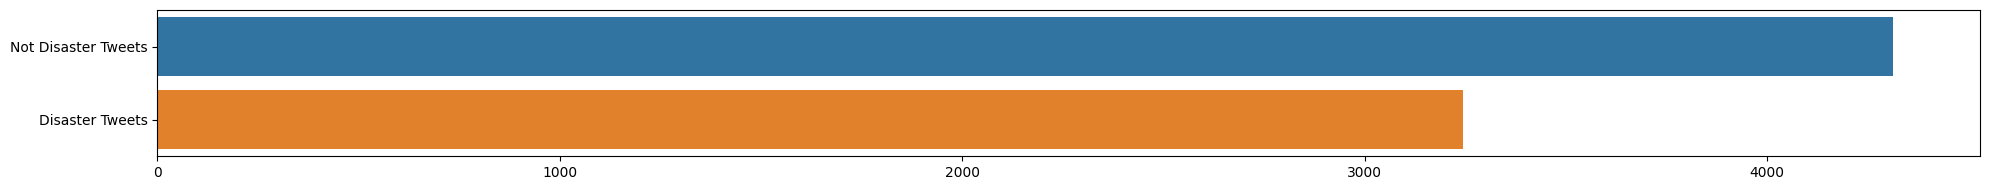

In [34]:
# We now see the corresponding distribution of the categories

labels = ["Not Disaster Tweets", "Disaster Tweets",]
values = [df_train_cleaned[df_train_cleaned['target'] == 0].shape[0], df_train_cleaned[df_train_cleaned['target'] == 1].shape[0]]

plt.figure(figsize=(20, 2))
sns.barplot(y=labels, x=values,hue=labels)
plt.tight_layout();


The inconsistent tags are a serious problem, but also there might be a problem in case of consistent repeated texts, as they could cause overftting. They will be removed now

In [35]:
# Remove duplicates
df_train_cleaned = df_train_cleaned.drop_duplicates(subset=['text'])

# Check train data counts. Originally training data has 1490 rows and 50 rows should be dropped. So, I expect 1440 rows left.
print(f'Samples in training data after moving duplicates: {df_train_cleaned.shape[0]}')



Samples in training data after moving duplicates: 7485


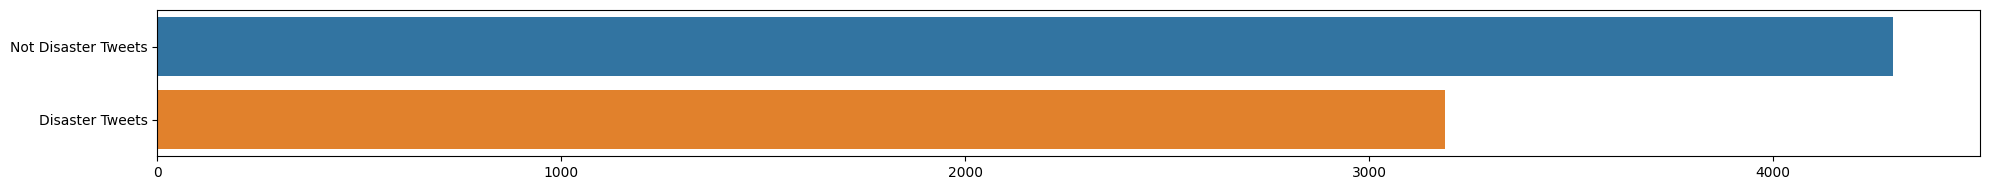

In [36]:
# We now see the corresponding distribution of the categories

labels = ["Not Disaster Tweets", "Disaster Tweets",]
values = [df_train_cleaned[df_train_cleaned['target'] == 0].shape[0], df_train_cleaned[df_train_cleaned['target'] == 1].shape[0]]

plt.figure(figsize=(20, 2))
sns.barplot(y=labels, x=values,hue=labels)
plt.tight_layout();

## Preprocess the data

Since we deal with text data, some standard preprocess is needed. In this section the following actions are performed:

1. Studying the word frequencies.
2. Preprocessing: Treating mentions, hashtags, urls, etc.
3. Tokenizing the data.
4. Getting new features: (special words counting)
5. Analysis of word and counting features

In [37]:

BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
SEED = 412294
EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [38]:
from sklearn.model_selection import train_test_split

X = df_train_cleaned["text"]
y = df_train_cleaned["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=SEED)

X_test = df_test["text"]

In [39]:
#!python3 -m pip install wordninja num2words mplcyberpunk spacy==3.5.3

#!python3 -m spacy download en_core_web_lg


We note first that connecting words (the, a, an, and, to,
of,...) are among the most common ones, but they do not add any context to the text. <br>
They will be removed (by being considered "stop words"). Also, we see that as expected some words start by a "hashtag" since it is used for tagging in twitter. Hyperlinks also appear as can be seen below <br>
Some texts also contains emoticons, they will be threated as the word that they represent.<br>
Words wll then need to be tokenized (for instance using the root). Finally, each tweet will be vectorized.  

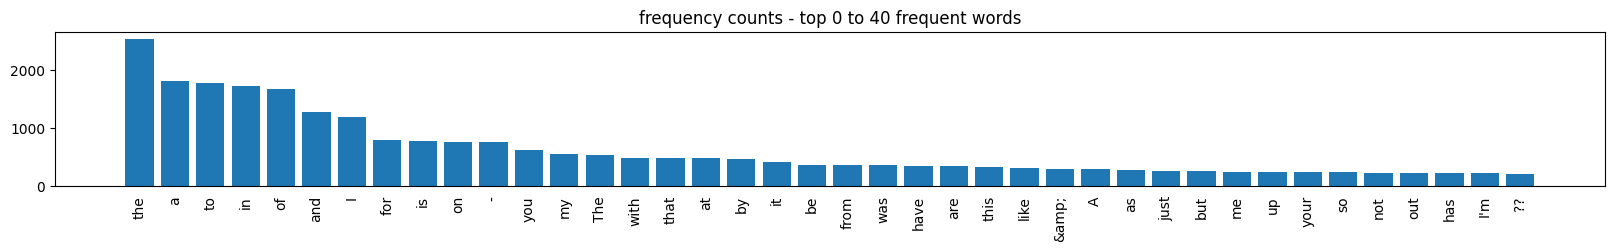

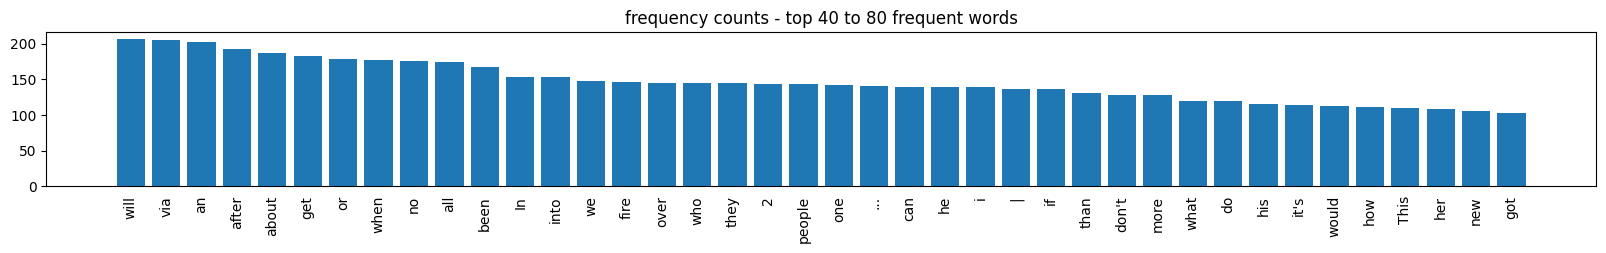

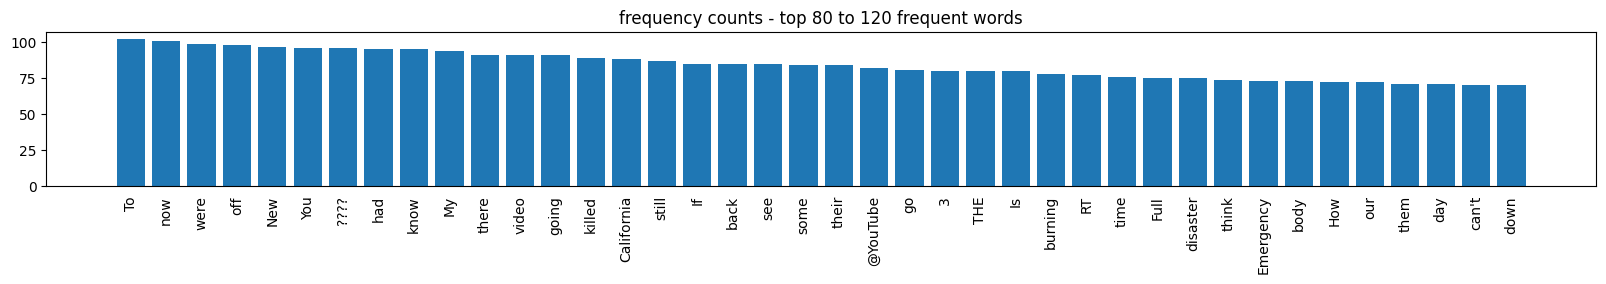

In [40]:
# plot some most frequent words
def frequency_plot(frequency,start,end):
    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency)
    plt.title(f'frequency counts - top {start} to {end} frequent words')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency = df_train_cleaned['text'].str.split().explode().value_counts()


frequency_plot(frequency,0,40)
frequency_plot(frequency, 40,80)
frequency_plot(frequency, 80,120)

In [41]:
print(len(frequency))
display(frequency.sort_index()[1000:1010])
frequency.sort_index()[21000:21010]

31870


text
#SuryaRay    1
#Susiya      1
#Suspense    1
#Swag        1
#Sydney      1
#Syria       2
#Syria.      1
#Syrian      1
#TAFS        1
#TBT         4
Name: count, dtype: int64

text
http://t.co/5BGcw3EzB5    1
http://t.co/5CGtqfk2uR    1
http://t.co/5Cm0LfZhxn    1
http://t.co/5CwUyLnFUm    1
http://t.co/5EBpYbFH4D    1
http://t.co/5FcJVMl520    1
http://t.co/5G8qA6mPxm    1
http://t.co/5GKTSHioRR    1
http://t.co/5IyZsDA6xB    1
http://t.co/5KohO39oJE    1
Name: count, dtype: int64

The following shows the most common words both in the disaster and non-disaster categories.

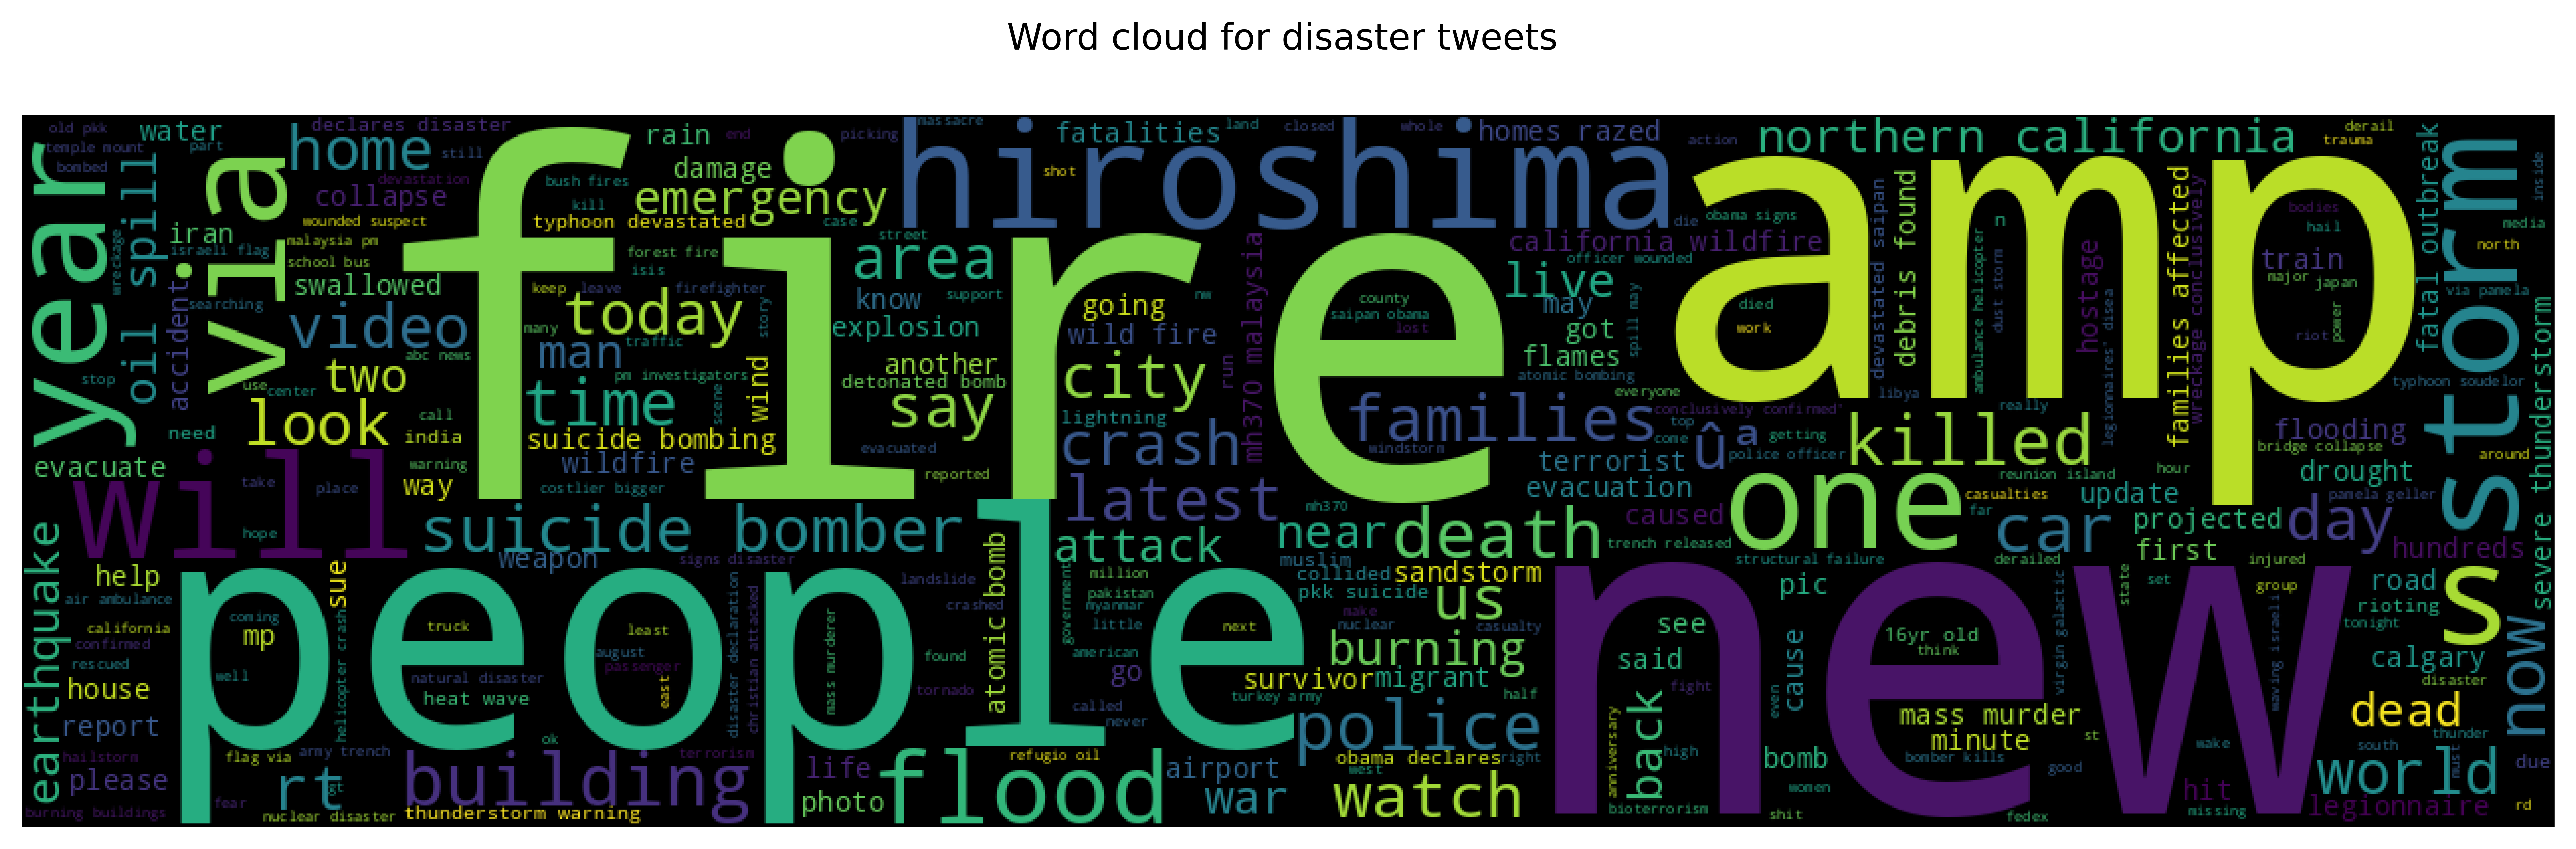

In [42]:
from wordcloud import WordCloud, STOPWORDS


aux = STOPWORDS.copy()
aux.update(["t"])
aux.update(["co"])
aux.update(["https"])
aux.update(["w"])
aux.update(["Û_"])
aux.update(["Û"])
aux.update(["U"])
aux.update(["ûᵃ"])
aux.update(["ûò"])

alltext = ' '.join(df_train_cleaned.loc[df_train_cleaned['target'] == 1, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

plt.figure(figsize=(12, 4), dpi=1000)
plt.imshow(word_cloud)
plt.axis("off")
plt.suptitle("Word cloud for disaster tweets ")
plt.tight_layout();



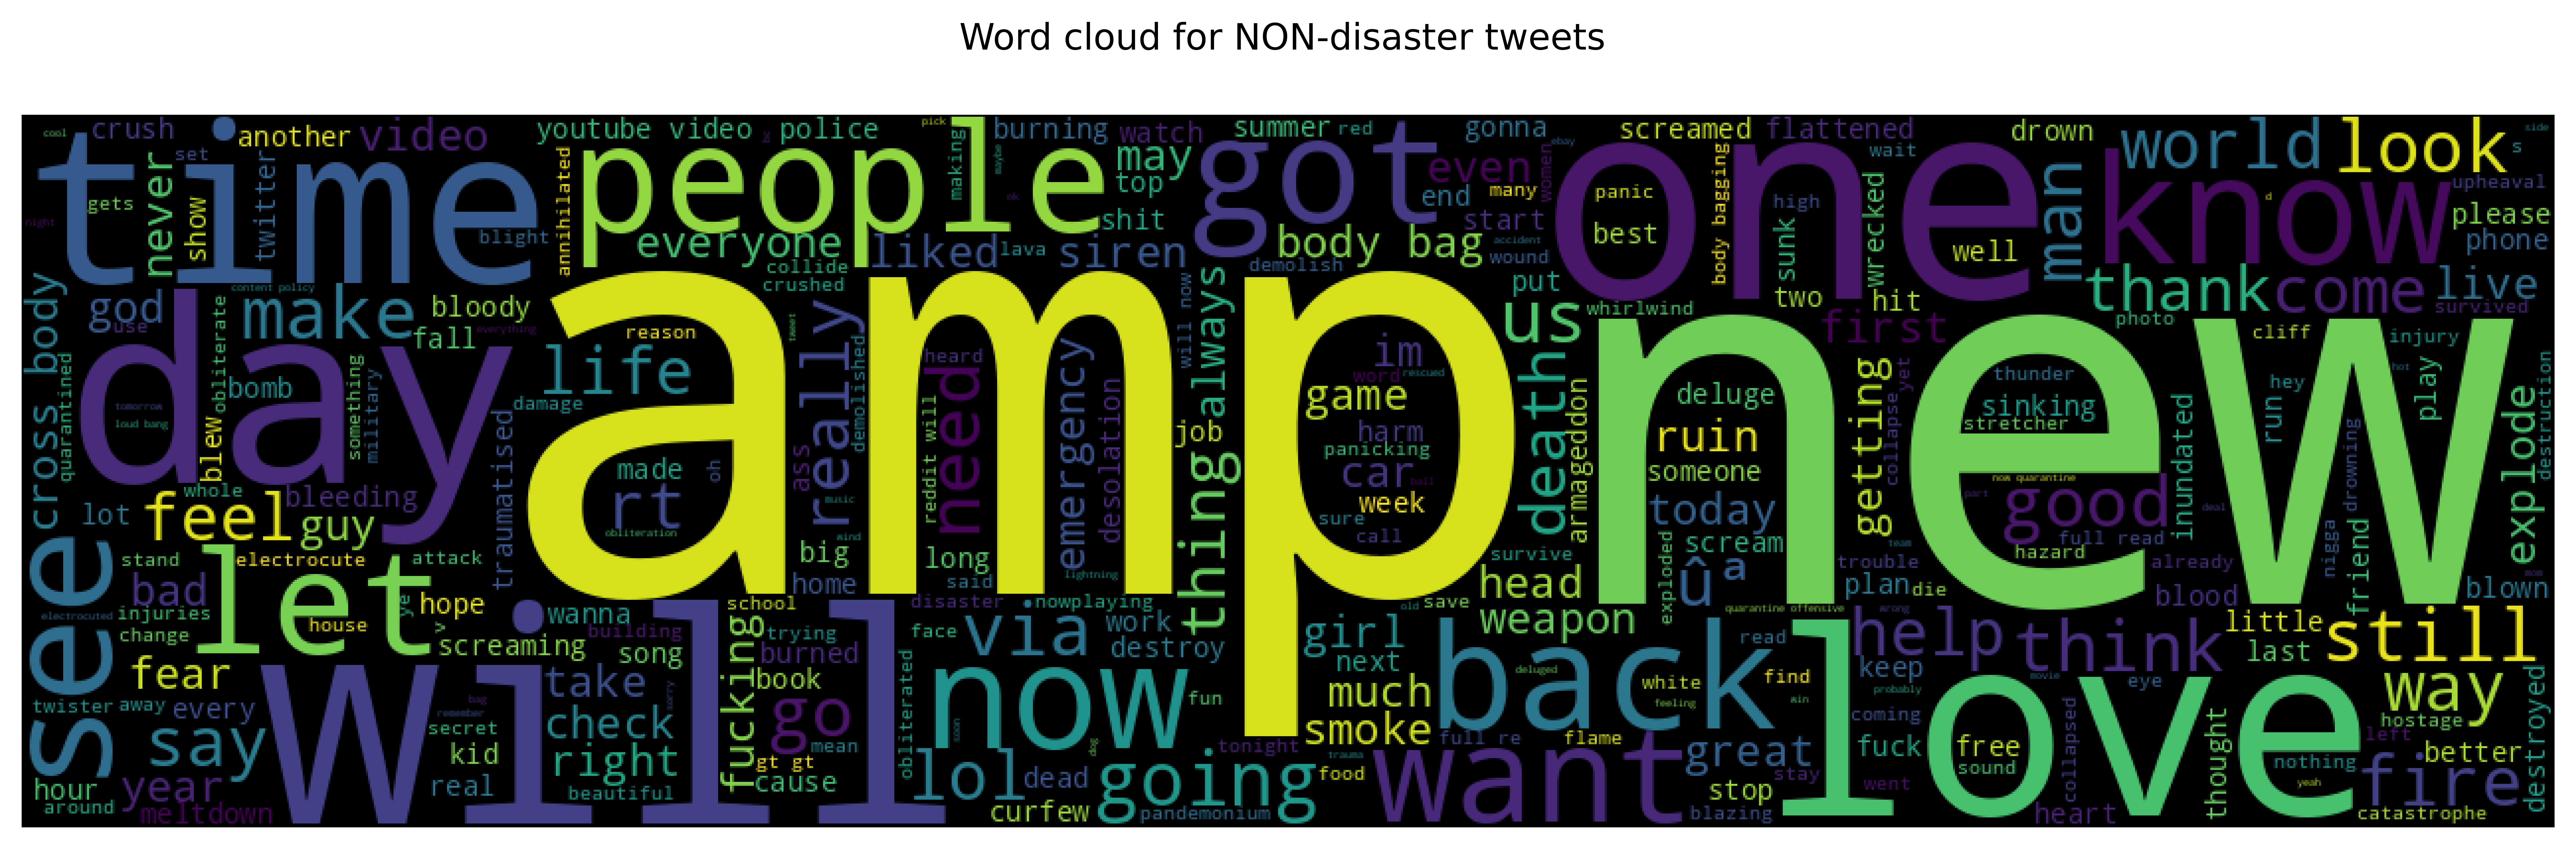

In [43]:
alltext = ' '.join(df_train_cleaned.loc[df_train_cleaned['target'] == 0, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

plt.figure(figsize=(12, 4), dpi=1000)
plt.imshow(word_cloud)
plt.axis("off")
plt.suptitle("Word cloud for NON-disaster tweets ")
plt.tight_layout();

In [44]:
print(f"The {len(aux)} stopwords like {list(aux)[:5]} will not be considered in the cleaned data")

The 201 stopwords like ['while', "i'm", 'and', 'that', 'would'] will not be considered in the cleaned data


In [45]:
#!pip install nltk --upgrade

In [46]:
# function for text preprocessing
import re
# nltk
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')  # Download stopwords dataset"stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer



EMOTICONS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def text_preprocessing(df):
    """
    This function does in place replacement of data so it won't return anything.
    Some symbols will be substituted by their corresponding words
    """
    # convert to lower cases
    df['text']=df['text'].str.lower()

    # change symbols

    df['text'] = df['text'].apply(lambda doc: re.sub(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', "anUrl ",doc)) # Replaces digits by "X"

    df['text'] = df['text'].apply(lambda doc: re.sub('\\$', ' dollar ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('£', ' pound sterling ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('€',  ' euro ',doc)) # eliminates dots ans spaces between numbers

    df['text'] = df['text'].apply(lambda doc: re.sub('%', ' percent ',doc)) # eliminates dots ans spaces between numbers

    df['text'] = df['text'].apply(lambda doc: re.sub(r'(\d)\.\s\:\,(\d)', r'\1',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub("\#", "aHashtag ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("([0-9])+", " aNumber ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("\@", "aMention ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub(r'Û', "",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub(r'û', "",doc)) # Replaces digits by "X"

    #changing emoticons
    for palabra, emoticon in EMOTICONS.items():
      df['text'] = df['text'].apply(lambda doc: re.sub(emoticon, f" aNemoji {palabra} ",doc)) # Replaces emoticon with its

    df['text'] = df['text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc)) #remove punctuation

    df['keyword'] = df['keyword'].apply(lambda doc: re.sub('%20', ' ',doc)) # in the keywords %20 is the code for " "

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')+list(aux)
    df['text'] = df['text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))



    # remove extra spaces
    df['text'] = df['text'].apply(lambda doc: re.sub(' +', ' ', doc))

    # stemming
    porter_stemmer = PorterStemmer()
    df['text'] = df['text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['text'] = df['text'].apply(lambda words: ' '.join(words))

    df['keyword'] = df['keyword'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['keyword'] = df['keyword'].apply(lambda words: ' '.join(words))

# take a look at text 0
train_copy = df_train_cleaned.copy().fillna('')
test_copy = df_test.copy().fillna('')

print('1st text before preprocessing: \n',train_copy['text'][0])
text_preprocessing(train_copy)
text_preprocessing(test_copy)

print('\n1st text after preprocessing: \n',train_copy['text'][0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1st text before preprocessing: 
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

1st text after preprocessing: 
 deed reason ahashtag earthquak may allah forgiv us


In [47]:
for k in range(8):
  print ("Original: ",(df_train_cleaned['text'][1000+k]))

  print ("Cleaned: ", (train_copy['text'][1000+k]))
  print(15*"-")


Original:  #OVOFest Drake straight body bagging Meek on that OVO stage. #ZIPHIMUP!
Cleaned:  ahashtag ovofest drake straight bodi bag meek ovo stage ahashtag ziphimup
---------------
Original:  I'm not a Drake fan but I enjoy seeing him body-bagging people. Great marketing lol.
Cleaned:  im drake fan enjoy see bodybag peopl great market lol
---------------
Original:  @amaramin3 Meek is definitely capable of body bagging his ass on the track Drake was just smooth as fuck with it!
Cleaned:  ament amaramin anumb meek definit capabl bodi bag ass track drake smooth fuck
---------------
Original:  Gates not body bagging nobody???????? niggas in br really know who he is ????
Cleaned:  gate bodi bag nobodi nigga br realli know
---------------
Original:  WWE 2k15 MyCareer EP18 Tyrone body bagging dudes: http://t.co/mr5bI4KD82 via @YouTube
Cleaned:  wwe anumb anumb mycar ep anumb tyron bodi bag dude anurl via ament youtub
---------------
Original:  'I did another one I did another one. You still

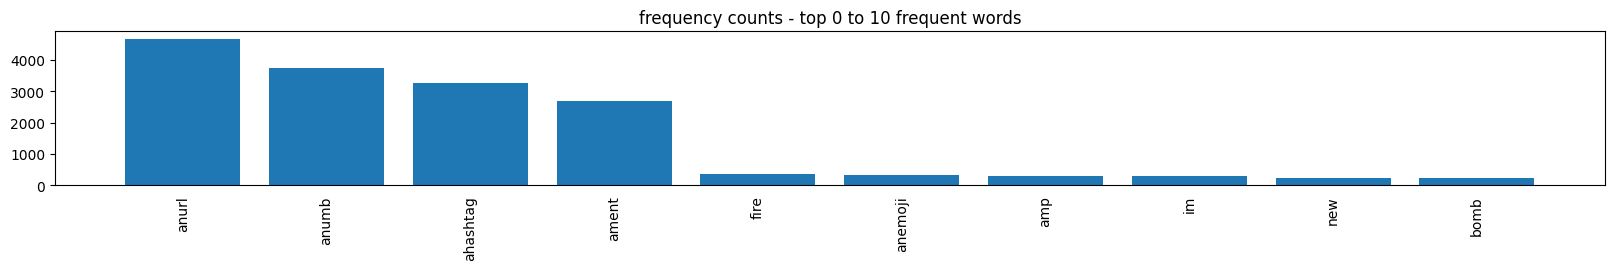

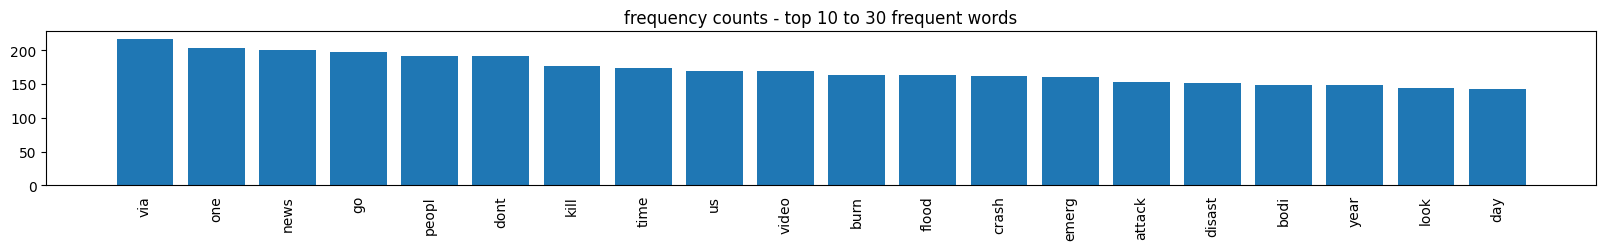

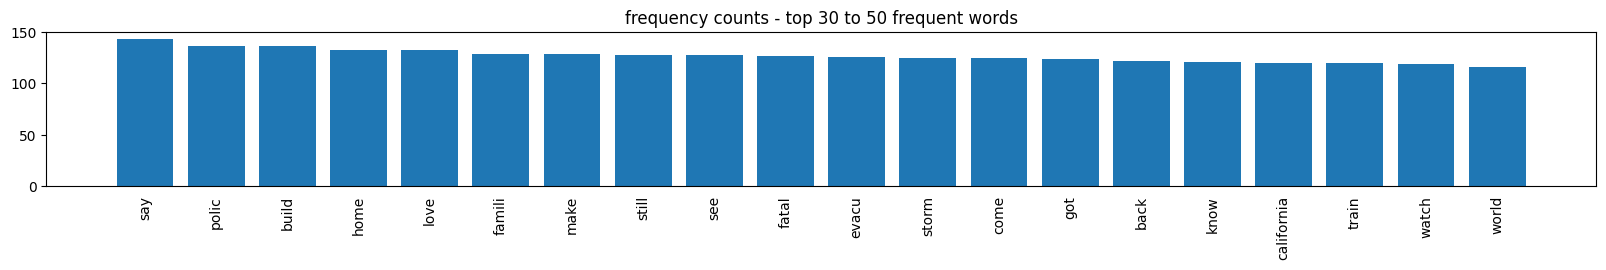

In [48]:
frequency = train_copy['text'].str.split().explode().value_counts()

frequency_plot(frequency,0,10)
frequency_plot(frequency, 10,30)
frequency_plot(frequency, 30,50)

### Further cleaning.
We can see that the most common strings are precisely those that contained hashtags, links, numbers, mentions and even emojis. We will keep track of the count of each of them in a new variable that may be introduced in the model.

In [49]:
def get_textData(clean_text):
  num_hashtags = clean_text.count('ahashtag')
  num_mentions = clean_text.count('ament')
  num_numbers = clean_text.count('anumb')
  num_urls = clean_text.count('anurl')
  num_emojis = clean_text.count('anemoji')

  clean_text = re.sub("ahashtag", "",clean_text)
  clean_text = re.sub("ament", "",clean_text)
  clean_text = re.sub("anumb", "",clean_text)
  clean_text = re.sub("anurl", "",clean_text)
  clean_text = re.sub("anemoji", "",clean_text)

  return clean_text, len(clean_text.split()), len(clean_text), num_hashtags, num_mentions, num_urls, num_numbers, num_emojis
print (get_textData(train_copy['text'][1024]))

('bestsel fossil dawson mini cross bodi bag esû_ dollar   ', 9, 56, 0, 0, 1, 2, 0)


Now, we need to tokenize the words and get a numeric dataframe that will be the input to our corresponding RNN models

In [50]:
train_copy["clean_text"],train_copy["n_words"], train_copy["n_characters"], train_copy["n_hashtags"], train_copy["n_mentions"], train_copy["n_urls"],train_copy["n_numbers"],train_copy["n_emojis"],  = zip(*train_copy["text"].apply(lambda text: get_textData(text)))
train_copy["n_keywords"]  = list(zip(*train_copy["keyword"].apply(lambda text: get_textData(text))))[1]
train_copy["n_location"]  = list(zip(*train_copy["location"].apply(lambda text: get_textData(text))))[1]

train_copy

id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7604  10863                    
7605  10864                    
7606  10866                    
7608  10869                    
7612  10873                    

                                                   text  target  length  \
0     deed reason ahashtag earthquak may allah forgi...       1      69   
1                  forest fire near la rong sask canada       1      38   
2     resid ask shelter place notifi offic evacu she...       1     133   
3     anumb anumb peopl receiv ahashtag wildfir evac...       1      65   
4     got sent photo rubi ahashtag alaska smoke ahas...       1      88   
...                                                 ...     ...     ...   
7604  ahashtag worldnew fallen powerlin glink tram u...       1     136   
7605  flip side im walmart bomb everyon evacu stay t...       1     114   
7606  suicid bomber kill anumb saudi secur site mosq...       1     121   
7608  two giant crane hold bridg collaps nearbi home...       1      83   
7612  latest home raze northern california wildfir a...       1      94   

                                             clean_text  n_words  \
0            deed reason  earthquak may allah forgiv us        7   
1                  forest fire near la rong sask canada        7   
2     resid ask shelter place notifi offic evacu she...       11   
3          peopl receiv  wildfir evacu order california        6   
4     got sent photo rubi  alaska smoke  wildfir pou...        9   
...                                                 ...      ...   
7604   worldnew fallen powerlin glink tram updat fir...       11   
7605  flip side im walmart bomb everyon evacu stay t...       10   
7606  suicid bomber kill  saudi secur site mosqu reu...       13   
7608    two giant crane hold bridg collaps nearbi home         8   
7612  latest home raze northern california wildfir a...        8   

      n_characters  n_hashtags  n_mentions  n_urls  n_numbers  n_emojis  \
0               42           1           0       0          0         0   
1               36           0           0       0          0         0   
2               69           0           0       0          0         0   
3               46           1           0       0          2         0   
4               54           2           0       0          0         0   
...            ...         ...         ...     ...        ...       ...   
7604            71           1           0       1          1         0   
7605            54           0           0       0          0         0   
7606            76           0           0       1          1         0   
7608            47           0           0       1          0         0   
7612            54           0           0       1          0         0   

      n_keywords  n_location  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0  
...          ...         ...  
7604           0           0  
7605           0           0  
7606           0           0  
7608           0           0  
7612           0           0  

[7485 rows x 16 columns]

### Tokenizing the text

The tokenizer module from "tensorflow.keras.preprocessing.text" creates a sequence of numbers (tokens) for each text in our dataset.
Such token is a number based on the frequency of the word in a larger text chosen to fit.

In our case, we need to fit the tokenizer based on the training data, and then we create the tokens for both training and testing data

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
def tokenize(text, tokenizer, fit=False):
    if fit == True:
        tokenizer.fit_on_texts(text)
    return tokenizer.texts_to_sequences(text)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenized_text = tokenize(train_copy['clean_text'][1], tokenizer, fit=True)
print (tokenized_text,train_copy['clean_text'][1])

[[7], [8], [3], [4], [5], [9], [], [7], [10], [3], [4], [], [6], [4], [2], [3], [], [11], [2], [], [3], [8], [6], [12], [], [5], [2], [5], [13], [], [14], [2], [6], [2], [15], [2]] forest fire near la rong sask canada


The following parameters were obained by checking the data. This will be used for setting up the input length of each part of the data

In [52]:
max_length_tweet = 20
max_length_keyword = 3
max_length_location = 8


In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_tokens(text, max_length, fit=False, padding=False):
    preprocessed_text = tokenize(text, tokenizer, fit)
    if padding:
        preprocessed_text = pad_sequences(preprocessed_text, maxlen=max_length, padding='post')
    return preprocessed_text

test_copy["clean_text"],test_copy["n_words"], test_copy["n_characters"], test_copy["n_hashtags"], test_copy["n_mentions"], test_copy["n_urls"],test_copy["n_numbers"], test_copy["n_emojis"],  = zip(*test_copy["text"].apply(lambda text: get_textData(text)))
test_copy["n_keywords"]  = list(zip(*test_copy["keyword"].apply(lambda text: get_textData(text))))[1]



train_copy["tokenized_text"] = list(get_tokens(train_copy["clean_text"].tolist(), max_length=max_length_tweet, fit=True, padding=True))
test_copy["tokenized_text"] = list(get_tokens(test_copy["clean_text"].tolist(), max_length=max_length_tweet, fit=False, padding=True))

train_copy["tokenized_keyword"] = list(get_tokens(train_copy["keyword"].tolist(), max_length=max_length_keyword, fit=True, padding=True))
test_copy["tokenized_keyword"] = list(get_tokens(test_copy["keyword"].tolist(), max_length=max_length_keyword, fit=False, padding=True))

train_copy["tokenized_location"] = list(get_tokens(train_copy["location"].tolist(), max_length=max_length_location, fit=True, padding=True))
test_copy["tokenized_location"] = list(get_tokens(test_copy["location"].tolist(), max_length=max_length_location, fit=False, padding=True))

train_copy[train_copy["keyword"]!=""].head()


id keyword                       location  \
31  48   ablaz                     Birmingham   
32  49   ablaz  Est. September 2012 - Bristol   
33  50   ablaz                         AFRICA   
34  52   ablaz               Philadelphia, PA   
35  53   ablaz                     London, UK   

                                                 text  target  length  \
31           ament bbcmtd wholesal market ablaz anurl       1      55   
32  alway tri bring heavi ahashtag metal ahashtag ...       0      67   
33  ahashtag africanbaz break newsnigeria flag set...       1      82   
34                                      cri set ablaz       0      34   
35           plu side look sky last night ablaz anurl       0      76   

                                           clean_text  n_words  n_characters  \
31                      bbcmtd wholesal market ablaz         4            30   
32                  alway tri bring heavi  metal  rt         6            33   
33   africanbaz break newsnigeria flag set ablaz aba         7            49   
34                                      cri set ablaz        3            13   
35                plu side look sky last night ablaz         7            35   

    n_hashtags  n_mentions  n_urls  n_numbers  n_emojis  n_keywords  \
31           0           1       1          0         0           1   
32           2           0       1          0         0           1   
33           1           0       1          0         0           1   
34           0           0       0          0         0           1   
35           0           0       1          0         0           1   

    n_location                                     tokenized_text  \
31           1  [5333, 2086, 264, 521, 0, 0, 0, 0, 0, 0, 0, 0,...   
32           5  [259, 146, 630, 731, 1036, 56, 0, 0, 0, 0, 0, ...   
33           1  [5334, 179, 5335, 579, 147, 521, 979, 0, 0, 0,...   
34           2  [694, 147, 521, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
35           2  [1490, 496, 26, 790, 96, 209, 521, 0, 0, 0, 0,...   

   tokenized_keyword                      tokenized_location  
31       [326, 0, 0]             [1463, 0, 0, 0, 0, 0, 0, 0]  
32       [326, 0, 0]  [5701, 14576, 14577, 2530, 0, 0, 0, 0]  
33       [326, 0, 0]              [635, 0, 0, 0, 0, 0, 0, 0]  
34       [326, 0, 0]           [1771, 743, 0, 0, 0, 0, 0, 0]  
35       [326, 0, 0]            [137, 172, 0, 0, 0, 0, 0, 0]

In [55]:
test_copy.head(5)

id keyword location                                               text  \
0   0                                            happen terribl car crash   
1   2                   heard ahashtag earthquak differ citi stay safe...   
2   3                   forest fire spot pond gees flee across street ...   
3   9                    apocalyps light ahashtag spokan ahashtag wildfir   
4  11                            typhoon soudelor kill anumb china taiwan   

   length                                         clean_text  n_words  \
0      34                           happen terribl car crash        4   
1      64     heard  earthquak differ citi stay safe everyon        7   
2      96  forest fire spot pond gees flee across street ...        9   
3      40                   apocalyps light  spokan  wildfir        4   
4      45                typhoon soudelor kill  china taiwan        5   

   n_characters  n_hashtags  n_mentions  n_urls  n_numbers  n_emojis  \
0            24           0           0       0          0         0   
1            46           1           0       0          0         0   
2            50           0           0       0          0         0   
3            32           2           0       0          0         0   
4            35           0           0       0          1         0   

   n_keywords                                     tokenized_text  \
0           0  [194, 1664, 50, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1           0  [383, 214, 824, 143, 406, 1236, 181, 0, 0, 0, ...   
2           0  [141, 2, 594, 2913, 1, 3175, 732, 445, 177, 0,...   
3           0  [368, 291, 5735, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
4           0  [459, 575, 13, 397, 1021, 0, 0, 0, 0, 0, 0, 0,...   

  tokenized_keyword        tokenized_location  
0         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
1         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
2         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
3         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
4         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(data, ngram_range=(1, 2)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    count_matrix = vectorizer.fit_transform(data)
    count_array = count_matrix.toarray()
    bag_of_words = pd.DataFrame(data=count_array,columns = vectorizer.get_feature_names_out(), index=train_copy.index)
    return bag_of_words


#pos_list = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
#            "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", "PERSON",
#            "QUANTITY", "TIME", "WORK_OF_ART", "LOC", "MISC", "ORG", "PER"]
#pos_list = [pos.lower() for pos in pos_list]
def plot_top_words(data, bag_of_words, reverse=False,top=20):
    top_word_disaster = bag_of_words[data["target"] == 1].sum().sort_values(ascending=False)
    if reverse:
        top_word_disaster = top_word_disaster[::-1]
    top_word_disaster = top_word_disaster[:top]


    top_word_notdisaster = bag_of_words[data["target"] == 0].sum().sort_values(ascending=False)
    if reverse:
        top_word_notdisaster = top_word_notdisaster[::-1]
    top_word_notdisaster = top_word_notdisaster[:top]

    plt.subplots(1, 2, figsize=(8, 7), dpi=200)

    plt.subplot(1, 2, 1)
    sns.barplot(y=top_word_notdisaster.index, x=top_word_notdisaster, color='#08F7FE')
    plt.title("Not Disaster Tweets")
    plt.xlabel("Count")
    plt.ylabel("Word")

    plt.subplot(1, 2, 2)
    sns.barplot(y=top_word_disaster.index, x=top_word_disaster, color='#FE53BB')
    plt.title("Disaster Tweets");
    plt.xlabel("Count")
    plt.ylabel("Word")

    plt.suptitle(f"Top {top} words in tweets after preprocessing")
    plt.tight_layout()



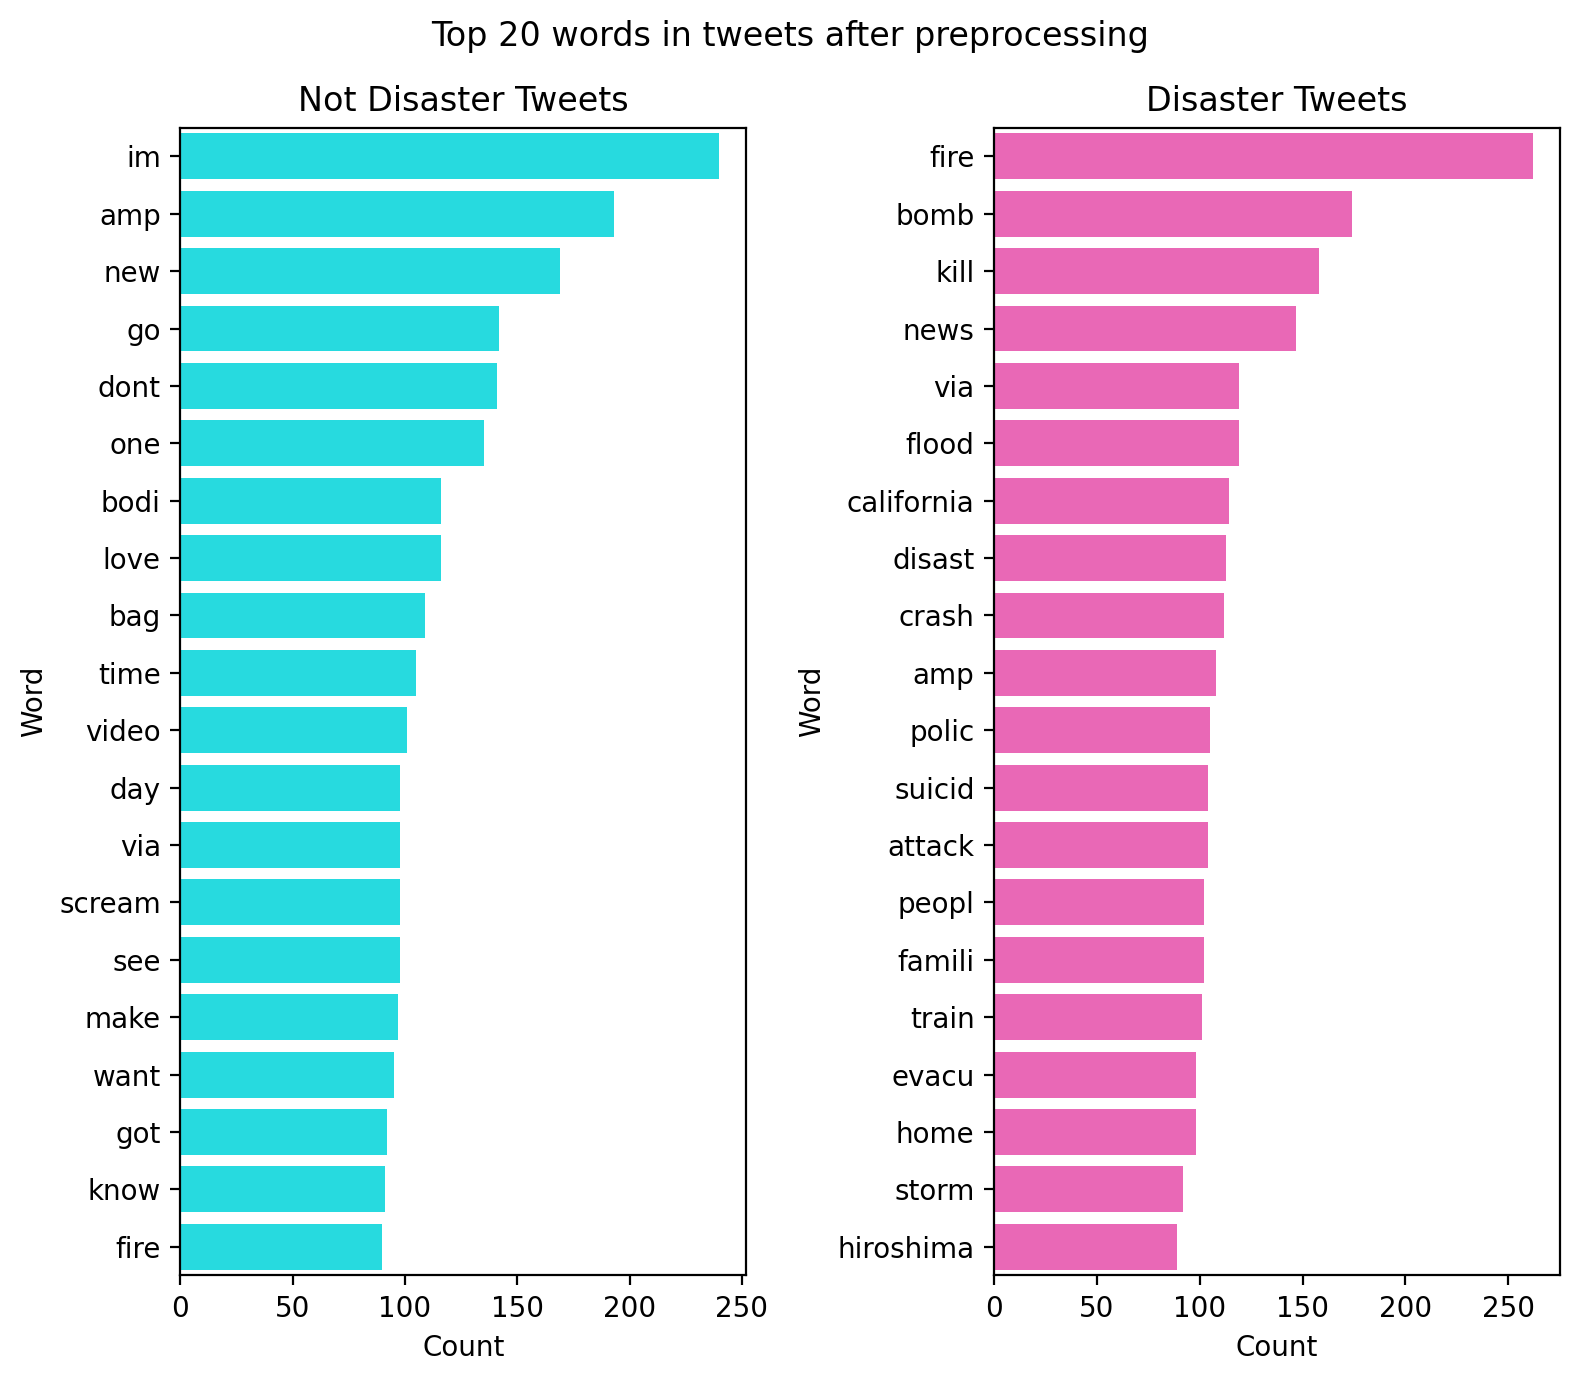

In [57]:
bag_of_words = get_top_n_words(data=train_copy['clean_text'], ngram_range=(1, 1))

plot_top_words(data=train_copy, bag_of_words=bag_of_words, top=20,reverse = False)



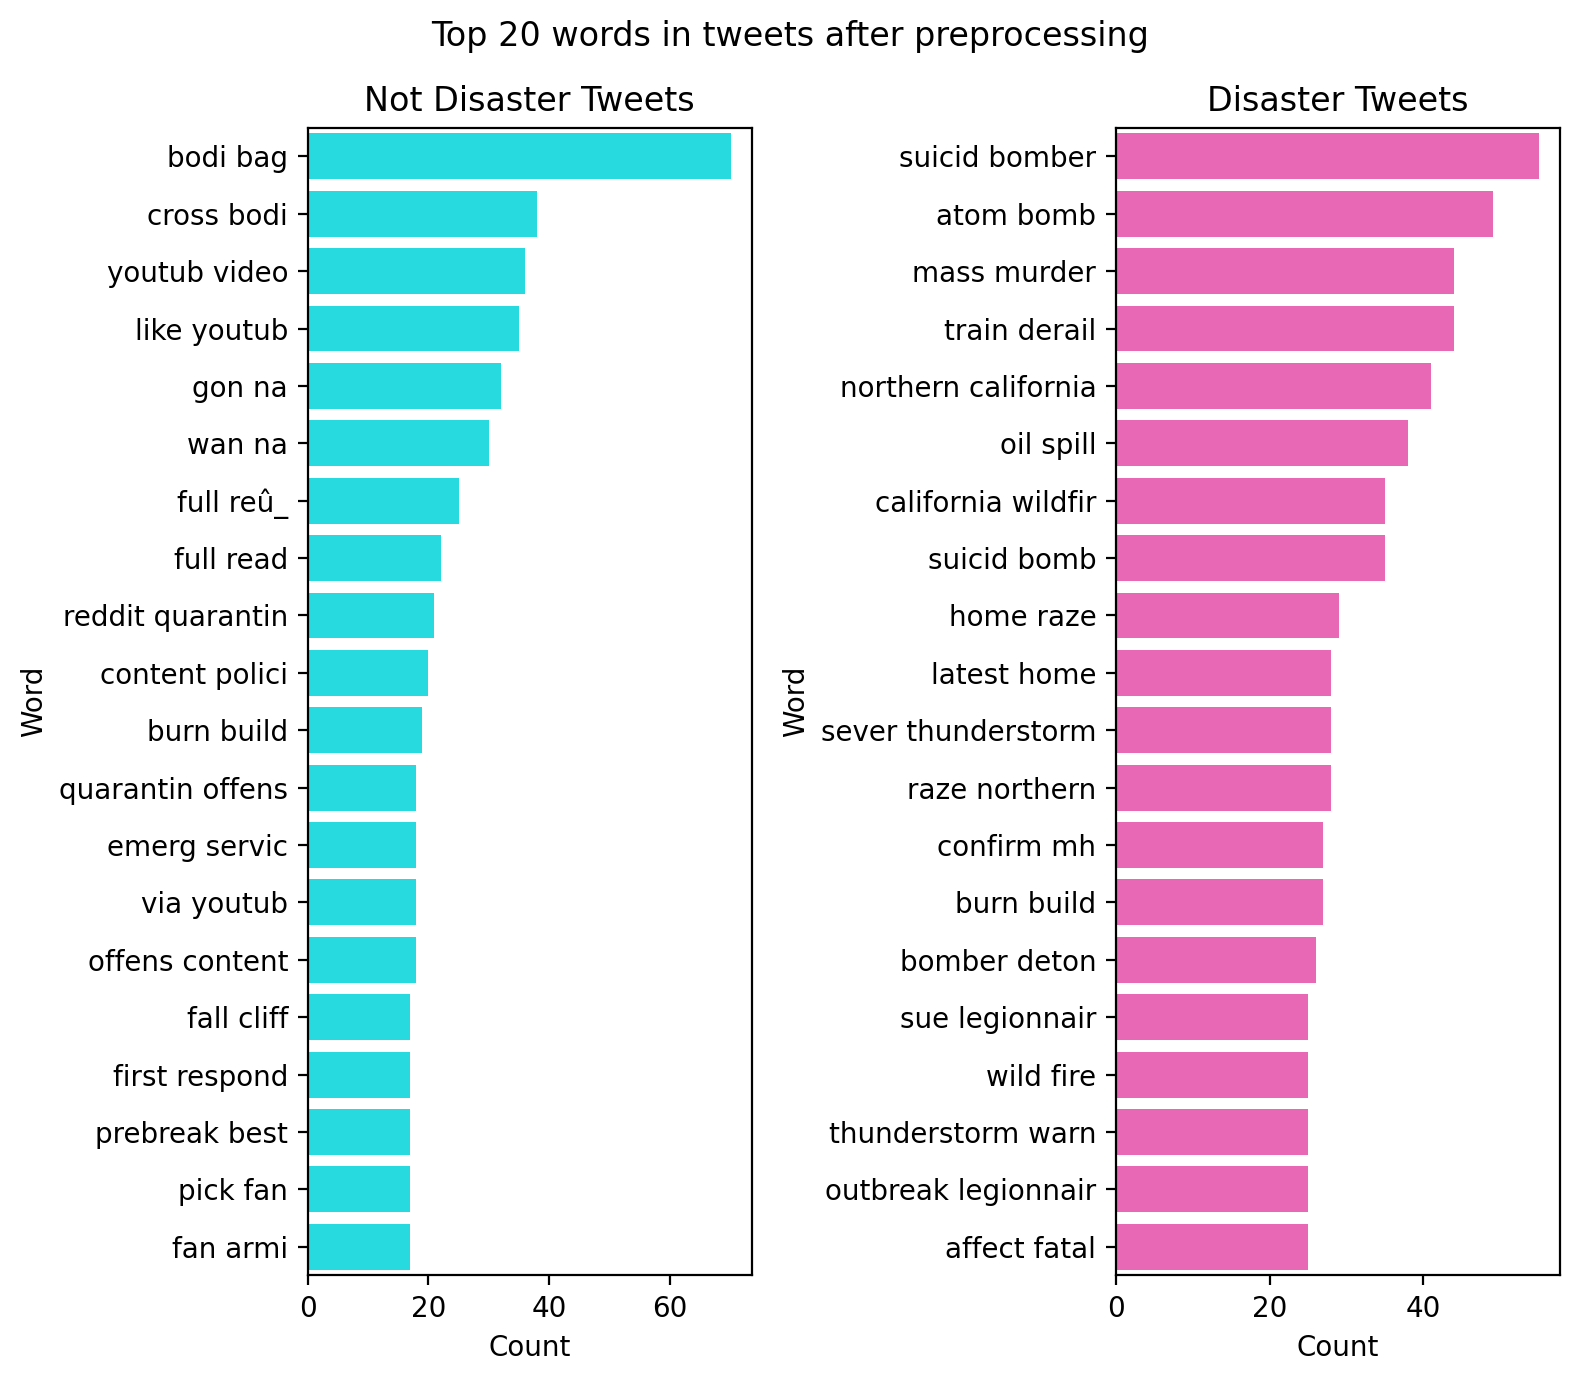

In [58]:
bag_of_words = get_top_n_words(data=train_copy['clean_text'], ngram_range=(2, 2))

plot_top_words(data=train_copy, bag_of_words=bag_of_words, top=20,reverse = False)


In [59]:


vocab_size = len(tokenizer.word_index) + 1
print(f"The tokenizer found {vocab_size} different words")


The tokenizer found 16338 different words


In [60]:
len(tokenizer.word_index) + 1


16338

In [61]:
import itertools
print(dict(itertools.islice(tokenizer.index_word.items(), 20)))

{1: '<OOV>', 2: 'fire', 3: 'new', 4: 'bomb', 5: 'amp', 6: 'im', 7: 'emerg', 8: 'burn', 9: 'via', 10: 'flood', 11: 'news', 12: 'one', 13: 'disast', 14: 'bodi', 15: 'go', 16: 'crash', 17: 'peopl', 18: 'dont', 19: 'attack', 20: 'build'}


### Analysis of the new features
The following code will generate visualizations for each of the (counting) features generated for each tweet.

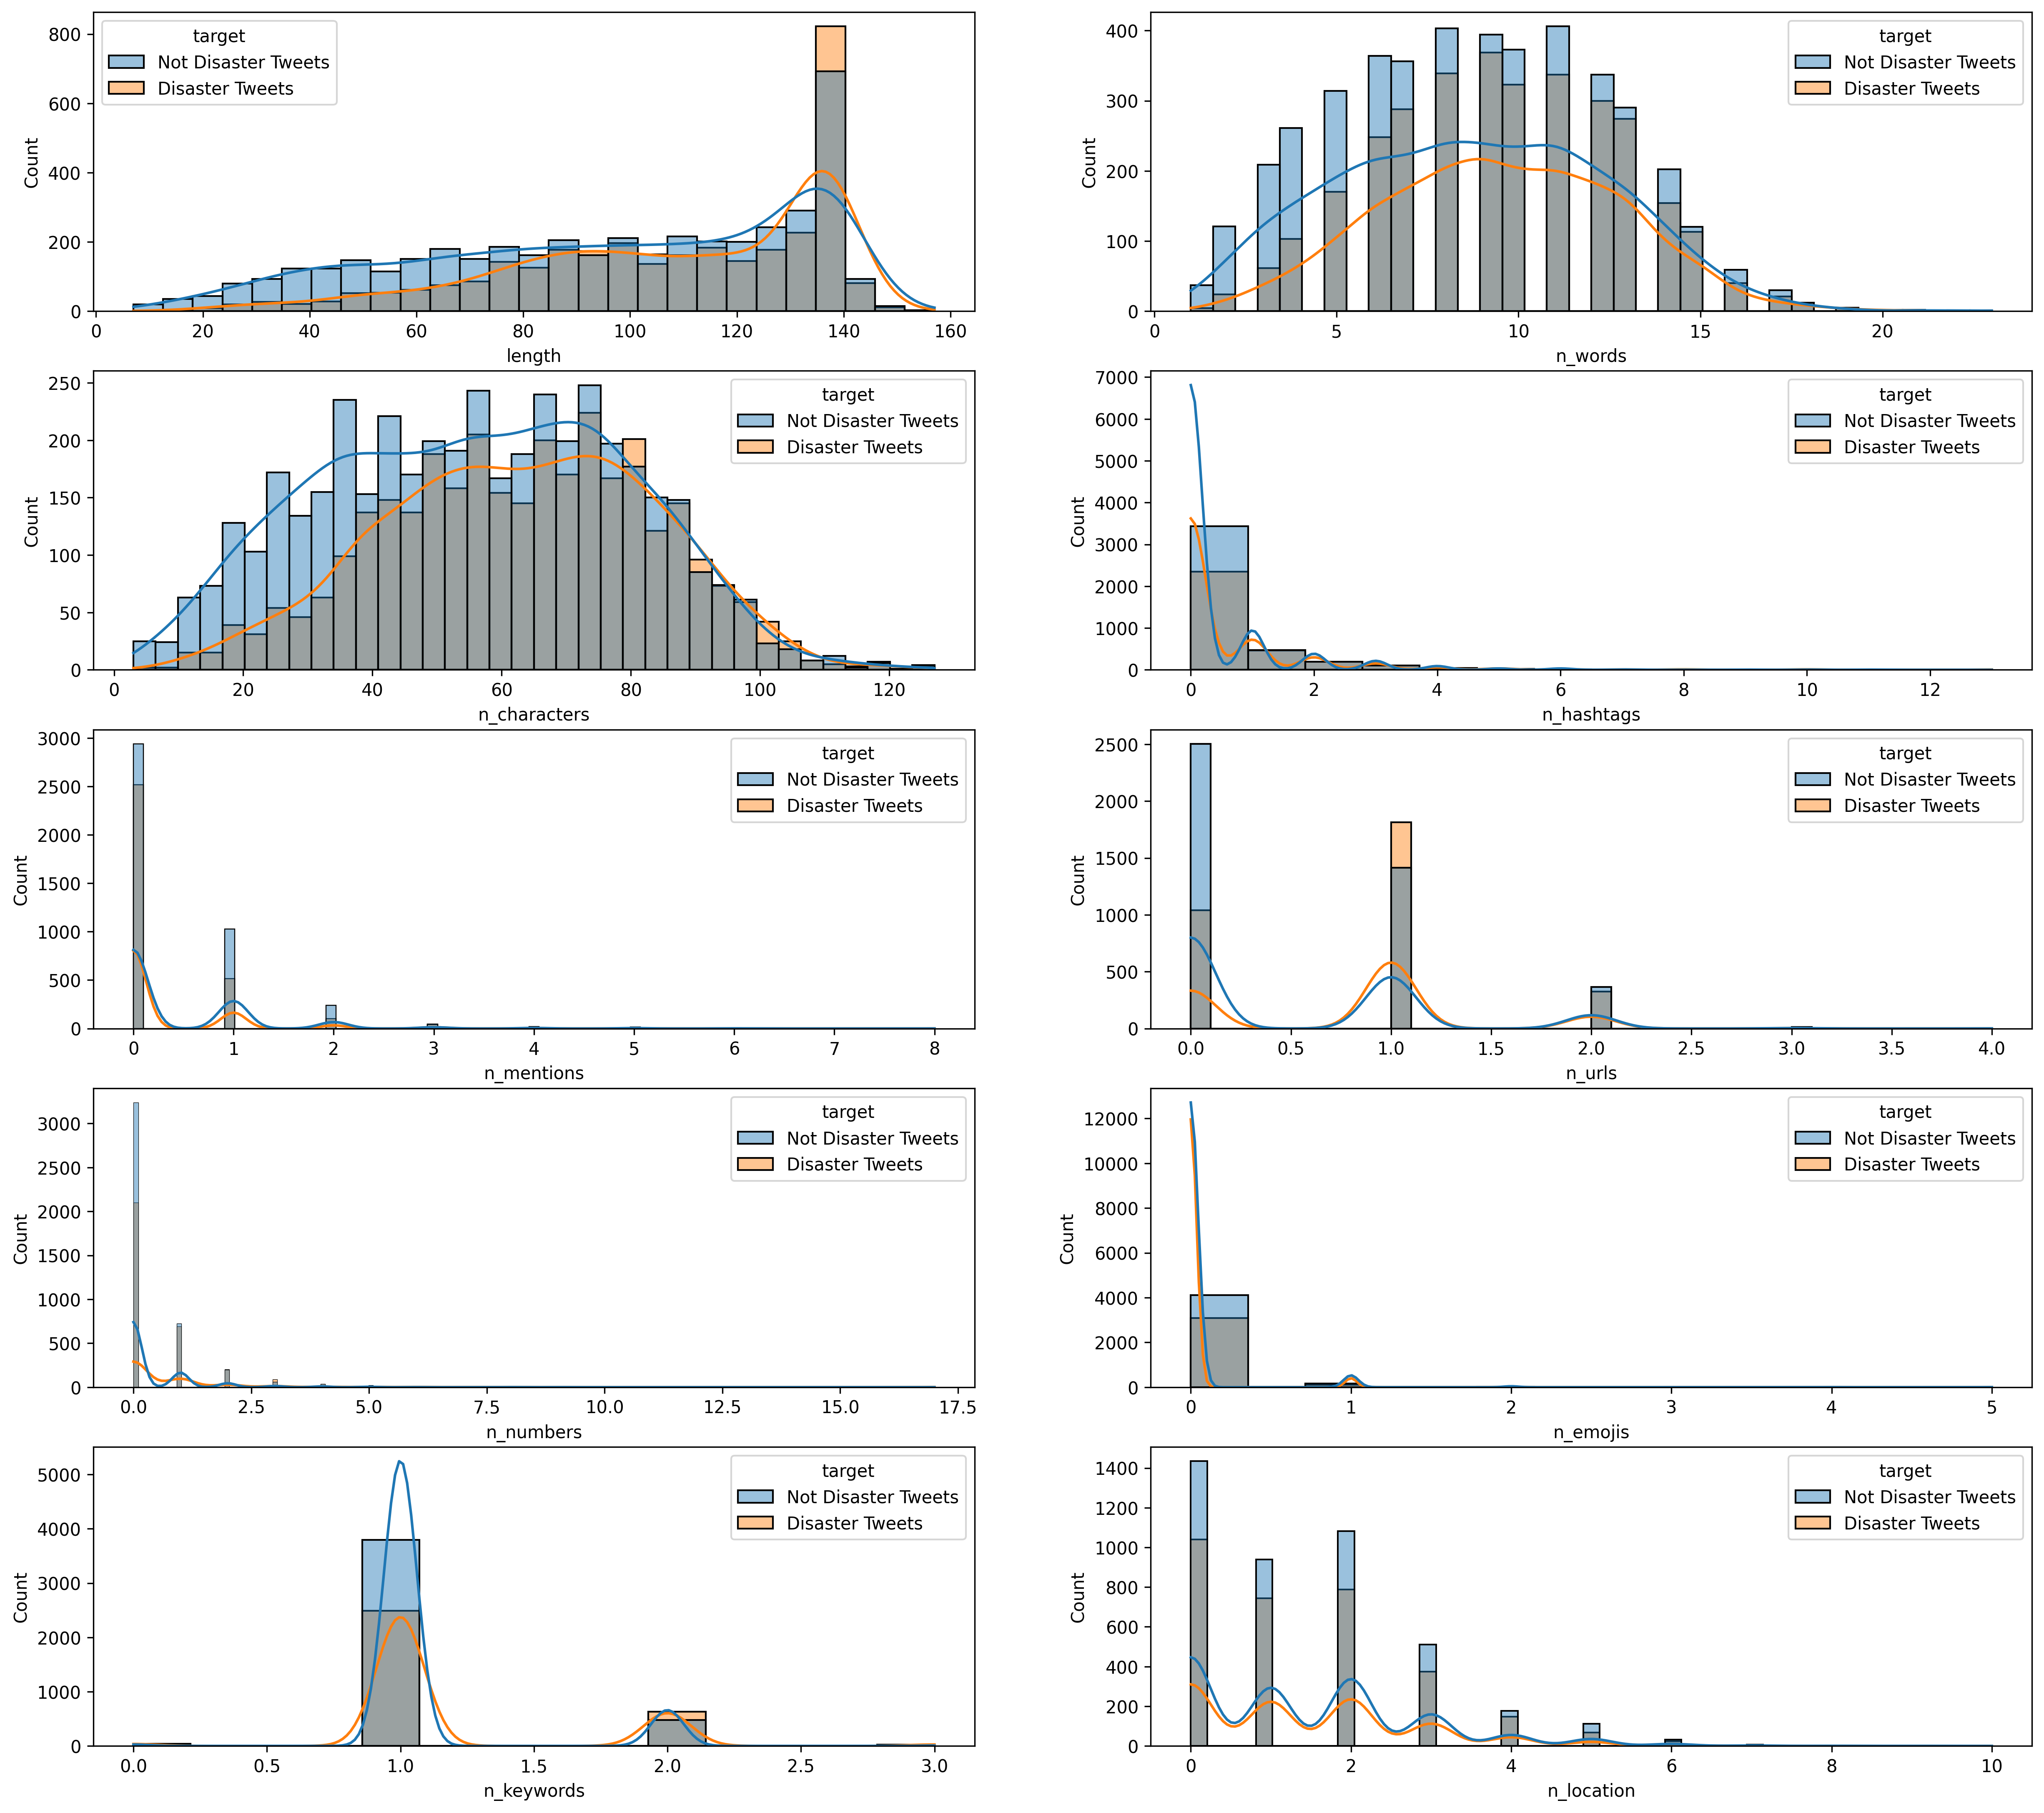

In [62]:
pd.set_option("mode.copy_on_write", False)
target = train_copy["target"].map({0: "Not Disaster Tweets", 1: "Disaster Tweets"})

plt.subplots(5, 2, figsize=(20, 18), dpi=300)
for i, col in enumerate(["length","n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers","n_emojis", "n_keywords", "n_location"]):
    plt.subplot(5, 2, i+1)
    sns.histplot(x=train_copy[col], hue=target, hue_order=["Not Disaster Tweets", "Disaster Tweets"], alpha=0.45, kde=True);

## Splitting data
In order to create the model and avoid overfitting the following standard strategy is done.

The training set is splitted in 3 parts. Training, validation and (pre)-test.
The model is optimized on the train set, with the parameters updated based on the validation one.
THe (pre)-test is used as unseen data to verify the model performance. A priori, the score obtained in the (pre)-test data will be similar to the one in the actual data to analyze.

Setting a seed will help for reproducing the same results.

In [63]:
import random

SEED = 41125
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [64]:
X = train_copy.drop(["target"], axis=1)
y = train_copy["target"]

#Creating the training and validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, shuffle=True, random_state=SEED)
X_train.head()



id        keyword       location  \
5760  8221           riot   Montana, USA   
523    755       avalanch        Ireland   
5327  7605    pandemonium  Mumbai, India   
147    211  airplan accid                  
1028  1493       bodi bag                  

                                                   text  length  \
5760  like ament youtub video anurl sick riot shield...      78   
523   littl piec wrote avalanch design blog id appre...     131   
5327  ament minhazmerch govt pass bill pandemonium u...      94   
147   expert franc begin examin airplan debri found ...     136   
1028  know hate bodi buy anumb bag chip varieti pack...     116   

                                             clean_text  n_words  \
5760    like  youtub video  sick riot shield slide spot        8   
523   littl piec wrote avalanch design blog id appre...       10   
5327   minhazmerch govt pass bill pandemonium upa us...        9   
147   expert franc begin examin airplan debri found ...       16   
1028  know hate bodi buy  bag chip varieti pack frui...       12   

      n_characters  n_hashtags  n_mentions  n_urls  n_numbers  n_emojis  \
5760            47           0           1       1          0         0   
523             63           0           0       1          0         0   
5327            56           0           1       0          0         0   
147            107           0           0       0          0         0   
1028            66           0           0       0          1         0   

      n_keywords  n_location  \
5760           1           2   
523            1           1   
5327           1           2   
147            2           0   
1028           2           0   

                                         tokenized_text tokenized_keyword  \
5760  [152, 71, 16, 975, 104, 11980, 1782, 594, 0, 0...        [70, 0, 0]   
523   [249, 850, 5854, 568, 1059, 1513, 366, 1897, 5...       [366, 0, 0]   
5327  [4951, 840, 642, 1433, 460, 11584, 100, 62, 43...       [295, 0, 0]   
147   [736, 938, 660, 1270, 384, 237, 218, 450, 322,...      [273, 47, 0]   
1028  [42, 523, 24, 916, 47, 3893, 3155, 1081, 1489,...       [14, 28, 0]   

                tokenized_location  
5760  [5587, 36, 0, 0, 0, 0, 0, 0]  
523    [1006, 0, 0, 0, 0, 0, 0, 0]  
5327  [670, 271, 0, 0, 0, 0, 0, 0]  
147       [0, 0, 0, 0, 0, 0, 0, 0]  
1028      [0, 0, 0, 0, 0, 0, 0, 0]

In [65]:
X_train_tokenized = X_train.loc[:, ["tokenized_text", "tokenized_keyword", "length","n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers","n_emojis"]]
X_val_tokenized = X_val.loc[:, ["tokenized_text", "tokenized_keyword", "length", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers", "n_emojis"]]
X_test_tokenized = X_test.loc[:, ["tokenized_text", "tokenized_keyword", "length", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers",  "n_emojis"]]

tokenized_X=dict()
tokenized_X["train"]=X_train_tokenized
tokenized_X["val"]=X_val_tokenized
tokenized_X["test"]=X_test_tokenized
display (tokenized_X["test"].head())
Y_s=dict()
Y_s["train"]=y_train
Y_s["val"]=y_val
Y_s["test"]=y_test



tokenized_text tokenized_keyword  \
2358  [8157, 3397, 630, 41, 491, 164, 2719, 0, 0, 0,...       [319, 0, 0]   
1216  [11, 662, 18, 28, 133, 11, 797, 55, 3193, 0, 0...        [20, 7, 0]   
6511  [12, 32, 524, 146, 87, 2519, 12815, 505, 0, 0,...        [60, 0, 0]   
7246  [152, 71, 16, 3694, 1484, 3695, 5, 91, 5, 973,...        [52, 0, 0]   
7269  [13669, 239, 360, 86, 0, 0, 0, 0, 0, 0, 0, 0, ...       [233, 0, 0]   

      length  n_words  n_characters  n_hashtags  n_mentions  n_urls  \
2358      68        7            58           0           2       0   
1216     103        9            52           0           0       0   
6511      77        8            47           0           0       0   
7246     129       11            83           0           2       1   
7269      41        4            32           0           1       0   

      n_numbers  n_emojis  
2358          0         0  
1216          0         0  
6511          0         0  
7246          1         0  
7269          0         0

In [66]:
print(tf.expand_dims(Y_s["test"], axis=-1).shape )


(749, 1)


In [67]:
from tensorflow.data import Dataset
datasets=dict()
datasets_text=dict()
datasets_keyword=dict()
datasets_counts=dict()
datasets_labels=dict()
for tipo in ["train", "val", "test"]:
  df=tokenized_X[tipo]
  text, keyword, counts = df["tokenized_text"].to_list(), df["tokenized_keyword"].to_list(), df.drop(["tokenized_text", "tokenized_keyword"], axis=1)
  data_text = Dataset.from_tensor_slices(text)
  data_keyword = Dataset.from_tensor_slices(keyword)
  data_counts = Dataset.from_tensor_slices(counts)
  data_labels = Dataset.from_tensor_slices(np.expand_dims(Y_s[tipo].values, axis=-1))

  datasets[tipo] = Dataset.zip(((data_text, data_keyword, data_counts), data_labels))
  datasets_text[tipo] = Dataset.zip(data_text,data_labels)
  datasets_keyword[tipo] = Dataset.zip(data_keyword,data_labels)
  datasets_counts[tipo] = Dataset.zip(data_counts,data_labels)
  datasets_labels[tipo] = data_labels

In [68]:
print(datasets["val"])
print(datasets_text["val"])


for tipo in ["train", "val", "test"]:
  datasets[tipo] = datasets[tipo].batch(32).prefetch(tf.data.AUTOTUNE)
  datasets_text[tipo] = datasets_text[tipo].batch(32).prefetch(tf.data.AUTOTUNE)
  datasets_keyword[tipo] = datasets_keyword[tipo].batch(32).prefetch(tf.data.AUTOTUNE)
  datasets_counts[tipo] = datasets_counts[tipo].batch(32).prefetch(tf.data.AUTOTUNE)
  datasets_labels[tipo] = datasets_labels[tipo].batch(32).prefetch(tf.data.AUTOTUNE)

<_ZipDataset element_spec=((TensorSpec(shape=(20,), dtype=tf.int32, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None), TensorSpec(shape=(8,), dtype=tf.int64, name=None)), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>
<_ZipDataset element_spec=(TensorSpec(shape=(20,), dtype=tf.int32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [69]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.8673232908458864, 1: 1.1805993690851735}

## Defining an architecture

As a baseline, we will consider that our dataset has 3 different types of data for each register:
1. Tokenized text
2. Tokenized keyword
3. Counts of specific text objects (hashtags, keywords, characters, words,...)

The first approach will be to consider simply the text and use LSTM as the recurrent part of the network.

LSTM splits the input sequences  into shorter batches, each of them will be used recursively. This recurrent part will be included as a whole block inside the neural network architectures.  

Some hyperparameters have been tested (manually). One of them is presented here.

The hyperparameters tested were:
* the length of LSTM blocks
* Learning rate for fitting the model
* Number of epochs


## A Simple Recurrent Neural Network:

This time, a recurrent neural network architecture will be tested as well.



In [70]:

def get_only_text_model():
    tf.keras.backend.clear_session()
    # Model for text
    inp1 = Input(shape=(max_length_tweet,), name="text")
    x = Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length_tweet)(inp1)
    x = Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.2))(x)
    out1 = Dense(1, activation="sigmoid")(x)


    model = Model(inputs=inp1, outputs=out1)
    return model

model_text = get_only_text_model()
model_text.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 20, 16)              │         261,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          41,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 303,009 (1.16 MB)

 Trainable params: 303,009 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

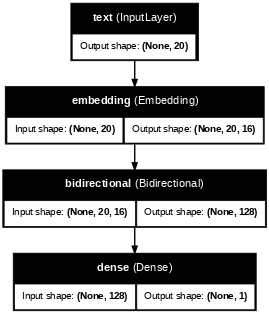

In [71]:
plot_model(model_text, show_layer_names=True, show_shapes=True, dpi=50)

In [72]:
LR = 0.001
EPOCHS=20
reduceLR = ReduceLROnPlateau(monitor='val_f1_score', patience=5, verbose=1)
early = EarlyStopping(monitor='val_f1_score', patience=8, verbose=1, restore_best_weights=True)




OPTIMIZER = Adam(learning_rate=LR)
# Step 3: Compile the model
model_text.compile(optimizer=OPTIMIZER , loss='binary_crossentropy',metrics=[F1Score(average = "weighted", threshold=0.5), BinaryAccuracy()])
# Step 4: Train the model
history_text = model_text.fit(datasets_text["train"],
                        validation_data=datasets_text["val"],
                        epochs=EPOCHS,
                        callbacks=[reduceLR, early, ],
                        class_weight=class_weight
                       )

# Step 5: Evaluate the model

# Reshape y_true before evaluation if necessary

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - binary_accuracy: 0.5497 - f1_score: 0.6073 - loss: 0.6579 - val_binary_accuracy: 0.7848 - val_f1_score: 0.7024 - val_loss: 0.4687 - learning_rate: 0.0010
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - binary_accuracy: 0.8439 - f1_score: 0.8099 - loss: 0.3856 - val_binary_accuracy: 0.7834 - val_f1_score: 0.7254 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - binary_accuracy: 0.9037 - f1_score: 0.8874 - loss: 0.2473 - val_binary_accuracy: 0.7687 - val_f1_score: 0.7232 - val_loss: 0.5782 - learning_rate: 0.0010
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - binary_accuracy: 0.9472 - f1_score: 0.9388 - loss: 0.1540 - val_binary_accuracy: 0.7420 - val_f1_score: 0.7026 - val_loss: 0.7349 - learning_rate: 0.0010
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - binary_accuracy: 0.9575 - f1_score: 0.9512 - loss: 0.1232 - val_binary_accuracy: 0.7340 - val_f1_sc

In [73]:
scores_text=model_text.evaluate(datasets_text["test"])
scores_text

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.7992 - f1_score: 0.7535 - loss: 0.4887


[0.49854665994644165, 0.7605633735656738, 0.7957276105880737]

### Visualization of training scores

The following function lets us visualize the scores.

In [74]:


def show_history(modelo, parameters=None):
    df_hist = pd.DataFrame(modelo.history)

    h,w=1,len(parameters)
    size=3
    margin=0.5
    plt.subplots(h,w, figsize=(w*(size+margin), h*(size+margin)), dpi=300)

    for i, col in enumerate(parameters):
        plt.subplot(1, len(parameters), i+1)
        param = col[0].replace('_', ' ').title()
        plt.plot(df_hist.index, df_hist[col[0]], label=f"Training {param}")
        plt.plot(df_hist.index, df_hist[col[1]], label=f"Validation {param}")
        plt.ylabel(col[0].capitalize().replace("_", " "))
        plt.xlabel("Epoch")
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3, which="both")
        plt.title(f"{param} over epochs")

    #fig, axs = delete_empty_subplots(fig, axs)
    plt.tight_layout()
    plt.show()
    return


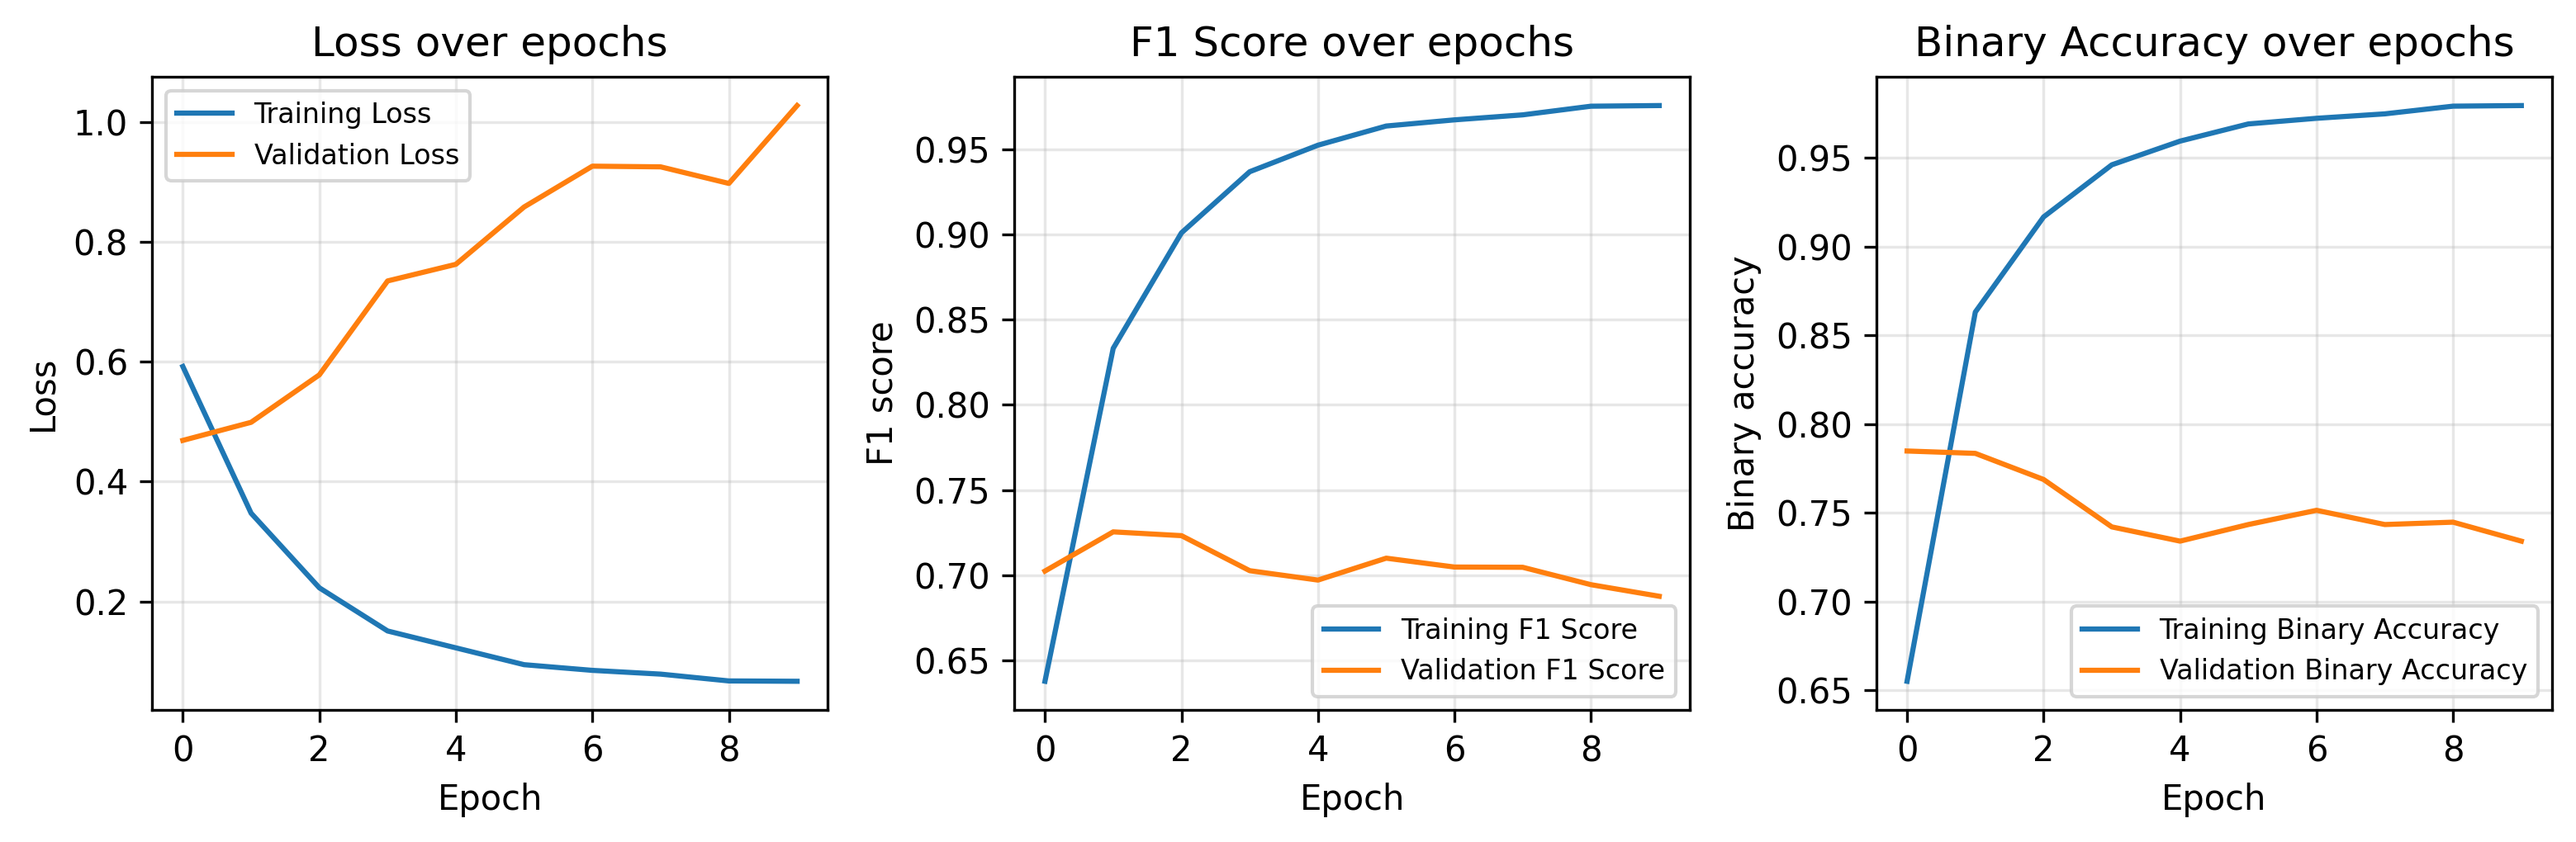

In [75]:
show_history(modelo=history_text, parameters=[["loss", "val_loss"],["f1_score", "val_f1_score"], ["binary_accuracy", "val_binary_accuracy"]])



We can see the confusion matrix too:

In [76]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step


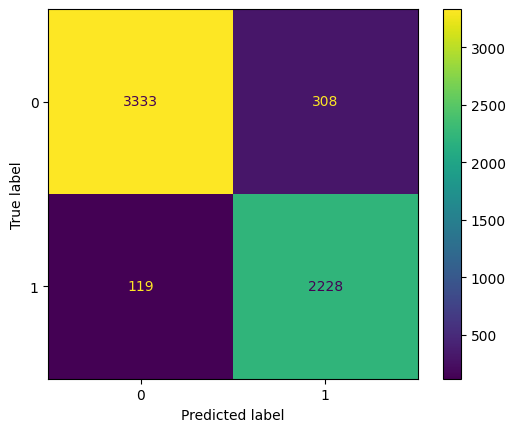

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


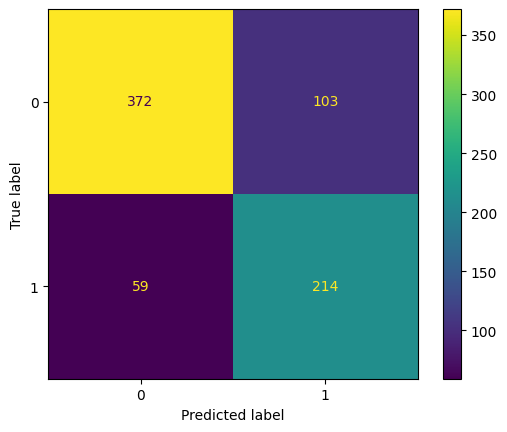

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


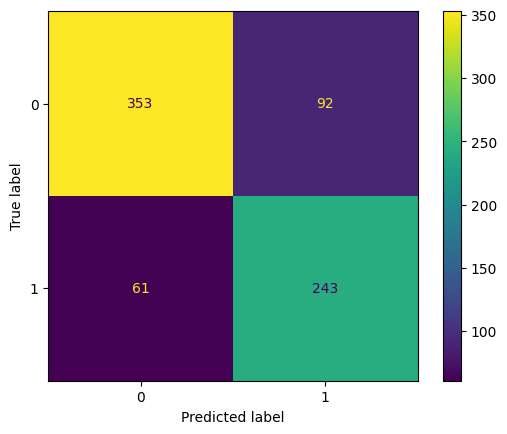

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
for tipo in ["train", "val", "test"]:
  y_pred_train = model_text.predict(datasets_text[tipo])
  y_pred_train =(y_pred_train>0.5)[:,0].astype(int)


  cm = confusion_matrix(y_pred_train,Y_s[tipo])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])

  disp.plot()
  plt.show()




## A second architecture

Since we have three different types of data: word counting data, tokenized text and tokenized keywords.
The second approach will simply use each of them separately to get an output and then try a weighted average of the results as the final output layer



In [78]:
def get_baseline_model():
    tf.keras.backend.clear_session()
    # Model for text
    inp1 = Input(shape=(max_length_tweet,), name="text")
    x = Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length_tweet)(inp1)
    x = Bidirectional(LSTM(16, dropout=0.4, recurrent_dropout=0.2))(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)

    out1 = Dense(1, activation="sigmoid")(x)

    # Model for keyword
    inp2 = Input(shape=(max_length_keyword,), name="keyword")
    t = Embedding(input_dim=vocab_size, output_dim=4, input_length=max_length_tweet)(inp2)
    t = Bidirectional(LSTM(3, dropout=0.3, recurrent_dropout=0.0))(t)
    out2 = Dense(1, activation="sigmoid")(t)

    # Model for word counts
    inp3 = Input(shape=(8,), name="counts")
    z = Dense(16, activation="relu")(inp3)
    z = Dropout(0.3)(z)
    z = Dense(8, activation="relu")(z)
    out3 = Dense(1, activation="sigmoid")(z)

    k = Concatenate()([out1, out2, out3])
    out = Dense(1, activation="sigmoid")(k)

    model = Model(inputs=[inp1, inp2, inp3], outputs=out)
    return model

model_base = get_baseline_model()
model_base.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 20, 16)         │        261,408 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ counts (InputLayer)       │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 32)             │          4,224 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keyword (InputLayer)      │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │            144 │ counts[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │            264 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 3, 4)           │         65,352 │ keyword[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8)              │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 6)              │            192 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 8)              │            136 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │              9 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │              7 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │              9 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │              4 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 331,749 (1.27 MB)

 Trainable params: 331,749 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

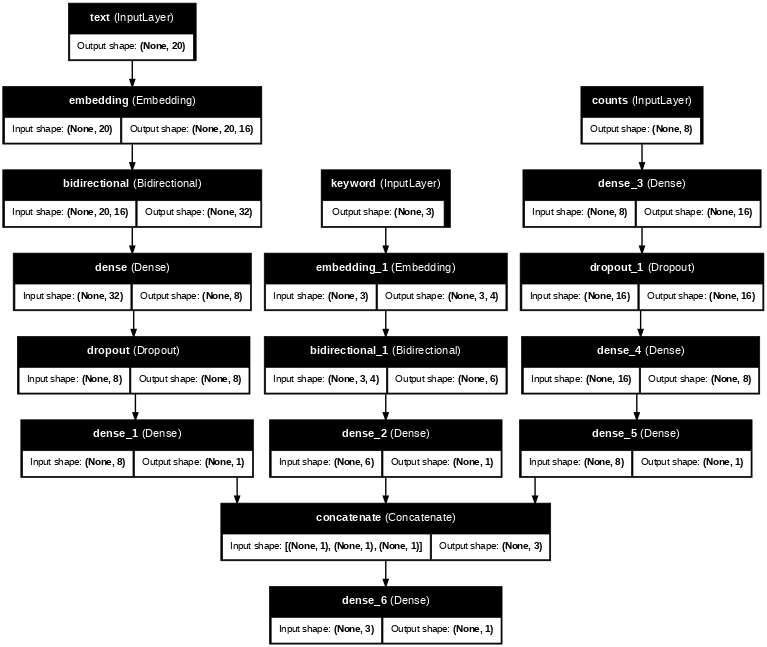

In [79]:
plot_model(model_base, show_layer_names=True, show_shapes=True, dpi=50)

In [80]:
LR = 0.001
EPOCHS=50
reduceLR = ReduceLROnPlateau(monitor='val_f1_score', patience=3, verbose=1)
early = EarlyStopping(monitor='val_f1_score', patience=8, verbose=1, restore_best_weights=True)


OPTIMIZER = Adam(learning_rate=LR)
# Step 3: Compile the model
model_base.compile(optimizer=OPTIMIZER , loss='binary_crossentropy',metrics=[F1Score(average = "weighted", threshold=0.5), BinaryAccuracy()])
# Step 4: Train the model
history_base = model_base.fit(datasets["train"],
                        validation_data=datasets["val"],
                        epochs=EPOCHS,
                        callbacks=[reduceLR, early, ],
                        class_weight=class_weight
                       )

# Step 5: Evaluate the model

# Reshape y_true before evaluation if necessary


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 177ms/step - binary_accuracy: 0.5264 - f1_score: 0.3883 - loss: 0.7045 - val_binary_accuracy: 0.5762 - val_f1_score: 0.0000e+00 - val_loss: 0.6799 - learning_rate: 0.0010
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step - binary_accuracy: 0.5301 - f1_score: 0.3656 - loss: 0.6905 - val_binary_accuracy: 0.6337 - val_f1_score: 0.2827 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - binary_accuracy: 0.7098 - f1_score: 0.6047 - loss: 0.6284 - val_binary_accuracy: 0.7701 - val_f1_score: 0.6803 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - binary_accuracy: 0.8365 - f1_score: 0.8017 - loss: 0.5709
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - binary_accuracy: 0.8365 - f1_score: 0.8017 - loss: 0.5708 - val_binary_accuracy: 0.7807 - val_f1_score: 0.7102 - val_loss: 0.5

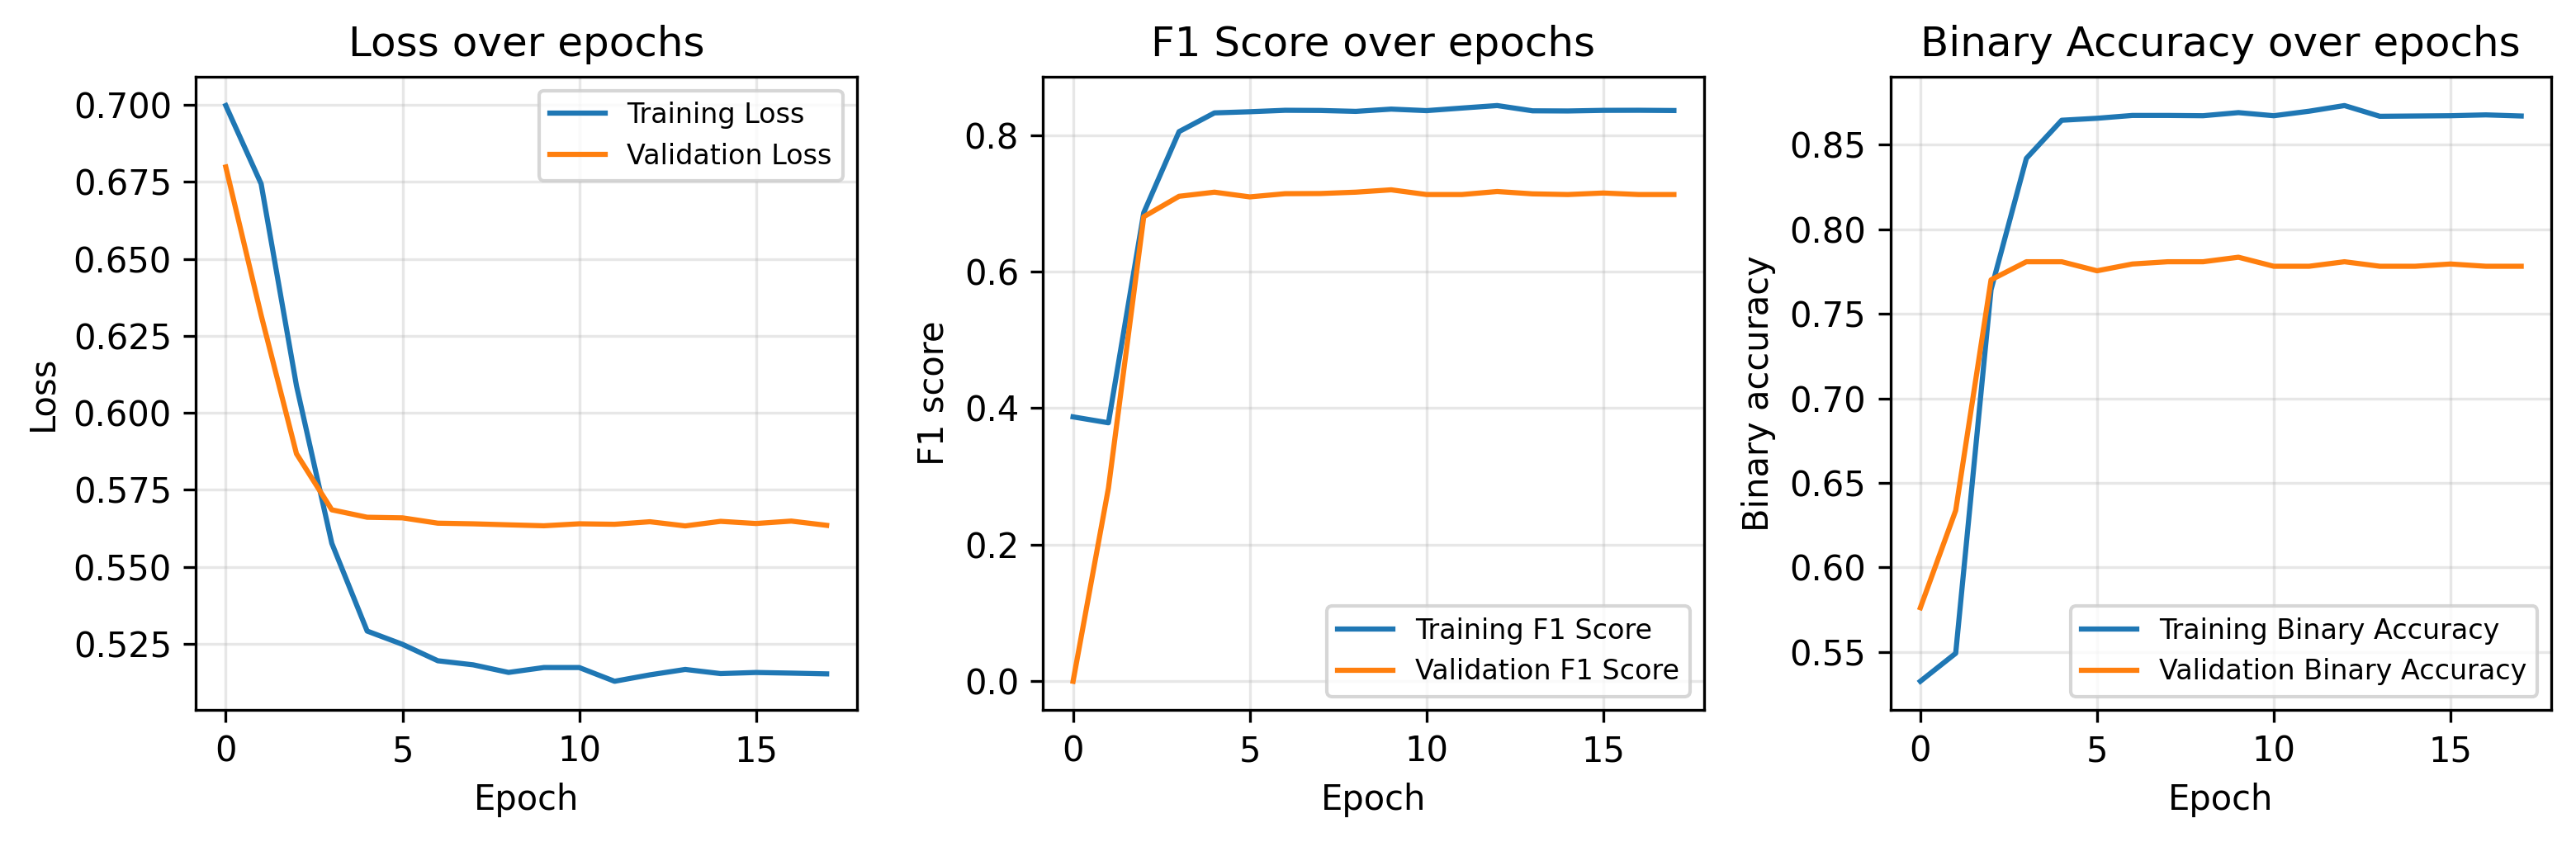

In [81]:
show_history(modelo=history_base, parameters=[["loss", "val_loss"],["f1_score", "val_f1_score"], ["binary_accuracy", "val_binary_accuracy"]])



In [82]:
scores_base = model_base.evaluate(datasets["test"])
scores_base

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.7662 - f1_score: 0.6964 - loss: 0.5598


[0.5618235468864441, 0.7266775369644165, 0.7770360708236694]

188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step


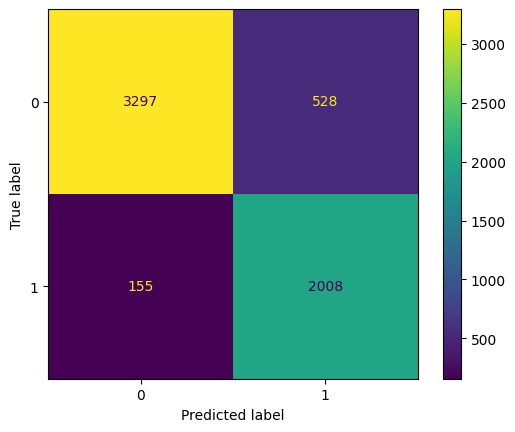

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


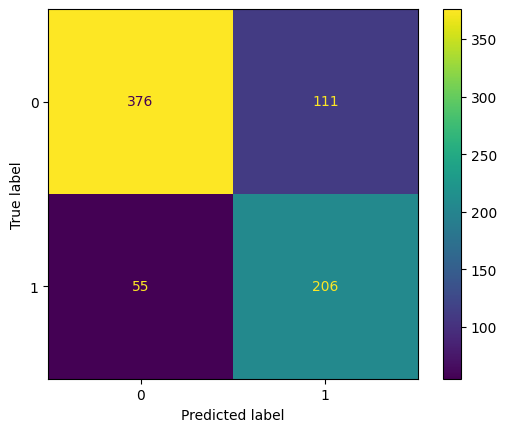

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


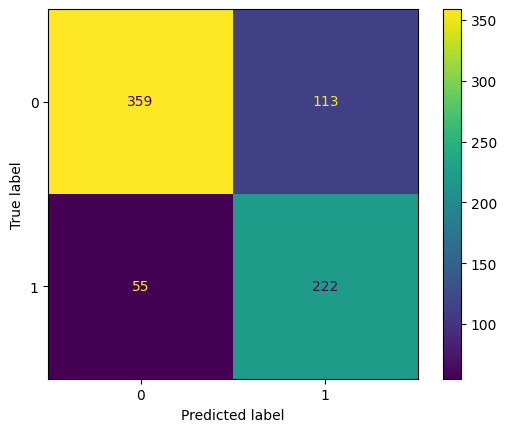

In [83]:
for tipo in ["train", "val", "test"]:
  y_pred_train = model_base.predict(datasets [tipo])
  y_pred_train =(y_pred_train>0.5)[:,0].astype(int)


  cm = confusion_matrix(y_pred_train,Y_s[tipo])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])

  disp.plot()
  plt.show()

We compare the scores for both models:


In [84]:
comparison = pd.DataFrame(data=[scores_text,scores_base], index=["Only text Model", "Base model"], columns=["Loss", "F1_Score", "Accuracy"])
comparison.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)


# Generate the submission file

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

One of the architectures defined previously was chosen to predict the target for the test data.



The `submission.csv` file uses the following format:
`id,target`

In [85]:
sample_submission = pd.read_csv(nlp_getting_started_path+"/sample_submission.csv")
sample_submission.head()

id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0

In [86]:

display(test_copy.head())

X_input_tokenized = test_copy.loc[:, ["tokenized_text", "tokenized_keyword", "length", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers",  "n_keywords"]]

text, keyword, counts = X_input_tokenized["tokenized_text"].to_list(), X_input_tokenized["tokenized_keyword"].to_list(), X_input_tokenized.drop(["tokenized_text", "tokenized_keyword"], axis=1)

data_text = Dataset.from_tensor_slices(text)
data_keyword = Dataset.from_tensor_slices(keyword)
data_counts = Dataset.from_tensor_slices(counts)

datasets_input = Dataset.zip(((data_text, data_keyword, data_counts)))
datasets_input = datasets_input.batch(32).prefetch(tf.data.AUTOTUNE)


print (len(test_copy))

id keyword location                                               text  \
0   0                                            happen terribl car crash   
1   2                   heard ahashtag earthquak differ citi stay safe...   
2   3                   forest fire spot pond gees flee across street ...   
3   9                    apocalyps light ahashtag spokan ahashtag wildfir   
4  11                            typhoon soudelor kill anumb china taiwan   

   length                                         clean_text  n_words  \
0      34                           happen terribl car crash        4   
1      64     heard  earthquak differ citi stay safe everyon        7   
2      96  forest fire spot pond gees flee across street ...        9   
3      40                   apocalyps light  spokan  wildfir        4   
4      45                typhoon soudelor kill  china taiwan        5   

   n_characters  n_hashtags  n_mentions  n_urls  n_numbers  n_emojis  \
0            24           0           0       0          0         0   
1            46           1           0       0          0         0   
2            50           0           0       0          0         0   
3            32           2           0       0          0         0   
4            35           0           0       0          1         0   

   n_keywords                                     tokenized_text  \
0           0  [194, 1664, 50, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1           0  [383, 214, 824, 143, 406, 1236, 181, 0, 0, 0, ...   
2           0  [141, 2, 594, 2913, 1, 3175, 732, 445, 177, 0,...   
3           0  [368, 291, 5735, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
4           0  [459, 575, 13, 397, 1021, 0, 0, 0, 0, 0, 0, 0,...   

  tokenized_keyword        tokenized_location  
0         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
1         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
2         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
3         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
4         [0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]

3263


In [87]:
print(datasets_input)
print (len(sample_submission))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>
3263


In [88]:
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np

def predict_with_dataset(model, dataset):
  """Predicts using a dataset and returns a numpy array."""
  predictions = []
  for batch in tqdm(dataset):
    text, keyword, counts = batch
    batch_prediction = model.predict([text, keyword, counts], verbose=0)  # verbose=0 to suppress output
    predictions.extend(batch_prediction)
  return np.array(predictions)



In [89]:
y_input_pred = predict_with_dataset(model_base, datasets_input)


  0%|          | 0/102 [00:00<?, ?it/s]

In [90]:
new_target = np.where(y_input_pred>0.5,1,0)[:,0]

In [91]:
sample_submission["target"] = new_target

In [92]:
sample_submission.describe()

id       target
count   3263.000000  3263.000000
mean    5427.152927     0.384002
std     3146.427221     0.486433
min        0.000000     0.000000
25%     2683.000000     0.000000
50%     5500.000000     0.000000
75%     8176.000000     1.000000
max    10875.000000     1.000000

In [93]:
sample_submission.to_csv("submission_base.csv", index=False)

For now the best result was this:

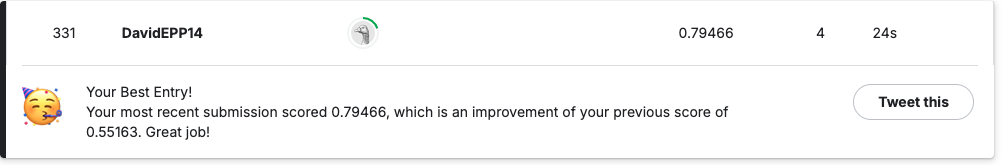

## Conclusions and further work

The model overfit to the training data, which might be a sign of a bad choice of some of the parameters in the construction of the model architecture.<br>
The model may be improved by doing grid search on the hyperparameters. <br>
There exists a pretrained model called BERT from Keras, this might give a better score. For now as it is a learning activity, this part was not tested yet.
Combininbg the daa cleaning from this model with the distilled version of BERT will be used in a next update

# References

1. https://www.kaggle.com/code/aletbm/nlp-with-disaster-tweets#Let's-train